<a href="https://colab.research.google.com/github/s-n-naik/Assessing-the-Funniness-of-Edited-News-Headlines-CodaLab/blob/main/CodaLab_Funniness_Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README

This notebook is structured into the following 6 sections:
- Setup
- Data Exploration
- Shared Functions
- Approach 1 (using pre-trained embeddings / models)
- Approach 2 (without pre-trained embeddings / models)
- Additional Experiments

We will describe each of them in turn.

---

**Setup**

We import all required libraries, check for a GPU for PyTorch and import 5 different datasets:
- **Training dataset:** used for W2V and regression model training
- **Validation dataset:** used for hyperparameter tuning
- **Test dataset:** used for final tests, remains untouched during hyperparameter tuning
- **Funlines dataset:** additional training data which has the same structure as the training data (*Source: https://www.cs.rochester.edu/u/nhossain/funlines.html*)
- **News Category dataset:** ca. 200k headlines with a broad range of topics, used to train a more comprehensive W2V model (*Source: https://www.kaggle.com/rmisra/news-category-dataset*)


---

**Data Exploration**

We explore our datasets to get a better understanding of the problem at hand as well as the data distribution. We exclude headlines with a particularly high standard deviation of the votes from our training set. 

---

**Shared Functions**

This section includes a set of training and evaluation methods which are used both for approach 1 and 2. All cells have to be excecuted to re-run the regression experiments. 

---

**Approach 1**

In this section we implement and run a BiLSTM and Transformer model.  To replicate results, run all cells in the "Setup" and "Shared functions" section described above.

For the BiLSTM, run all cells in "Model 1: BiLSTM" and for a transformer run all cells in "Model 2: Transformer".  Hyperparameters have already been chosen, but to modify them to trial a particular set of parameters use the penultimate cell in each subsection.  A description of each hyperparameter is described in each cell.

---

**Approach 2**

For approach 2, we first implemented a flexible data pre-processing pipeline. Next, we experimented with Bag of Words which yielded mediocre results on the regression task. Thus, we trained two Word2Vec models, one on the original training corpus and one on an augmented dataset (209k headlines). We then trained several Scikit-learn models and one LSTM based on the W2V models. 

Please ensure that the sections "Setup" and "Shared Functions" are executed before running all the cells in Approach 2 to ensure all required functions and datasets are loaded. Approach 2 is largely self-contained, however, to run the LSTM, it is necessary to initialise the class BiLSTM(nn.Module) in the Section "Approach 1, Model 1: BiLSTM".

---

**Additional Experiments**

This section includes experiments which we did not include in our final training approaches.
1. Manual byte pair encoding – turned out to be too computationally complex and difficult to retrieve useful tokens. We used FastText instead.
2. Manual word embedding training – too slow, we used Gensim's functions instead.

# Setup

In [ ]:
# Install language processing library Gensim
!pip install --upgrade  gensim

     |████████████████████████████████| 24.2MB 1.3MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
# Imports
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split
import torchtext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import codecs
import re
import pickle

#NLTK
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer

#GENSIM
from gensim.models import Word2Vec, FastText
from gensim.test.utils import common_texts

#SCIKIT-LEARN
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import ShuffleSplit, GridSearchCV, train_test_split
from sklearn.svm import SVR, NuSVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from IPython.display import display


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Setting random seed and device
SEED = 1

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

Using cpu


In [ ]:
# Load data from Google Drive
!wget -O train.csv https://drive.google.com/u/0/uc?id=1UgrdjcHHZmAthjusQDAKoSqd37up-41f&export=download
!wget -O dev.csv https://drive.google.com/u/0/uc?id=1rY6A0cN_cxAMK3aMHlTFWxhbcLFomvQL&export=download
train_df = pd.read_csv('train.csv', dtype= {'id': int, 'original': object, 'edit': object,'grades': object,'meanGrade': float} )
test_df = pd.read_csv('dev.csv', dtype= {'id': int, 'original': object, 'edit': object,'grades': object,'meanGrade': float})

--2021-03-02 20:27:15--  https://drive.google.com/u/0/uc?id=1UgrdjcHHZmAthjusQDAKoSqd37up-41f
Resolving drive.google.com (drive.google.com)... 108.177.12.100, 108.177.12.102, 108.177.12.139, ...
Connecting to drive.google.com (drive.google.com)|108.177.12.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-cc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7pp90cc1osue2q5lttsumat3v2guaak1/1614716775000/13802342090854404605/*/1UgrdjcHHZmAthjusQDAKoSqd37up-41f [following]
--2021-03-02 20:27:15--  https://doc-00-cc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7pp90cc1osue2q5lttsumat3v2guaak1/1614716775000/13802342090854404605/*/1UgrdjcHHZmAthjusQDAKoSqd37up-41f
Resolving doc-00-cc-docs.googleusercontent.com (doc-00-cc-docs.googleusercontent.com)... 173.194.215.132, 2607:f8b0:400c:c0c::84
Connecting to doc-00-cc-docs.googleusercontent.com (doc-00-cc-docs.googleusercontent.com)|1

In [ ]:
# Loading additional funny headlines data from Google Drive (Source: https://www.cs.rochester.edu/u/nhossain/funlines.html)
!wget -O train_funlines.csv https://drive.google.com/u/0/uc?id=1MAMXgkk1upDCc3_YkF94qfHLnRp26MKD&export=download
funlines_df = pd.read_csv('train_funlines.csv', dtype= {'id': int, 'original': object, 'edit': object,'grades': object,'meanGrade': float,})


--2021-03-02 20:27:17--  https://drive.google.com/u/0/uc?id=1MAMXgkk1upDCc3_YkF94qfHLnRp26MKD
Resolving drive.google.com (drive.google.com)... 108.177.12.139, 108.177.12.100, 108.177.12.113, ...
Connecting to drive.google.com (drive.google.com)|108.177.12.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0vethe4438jes5p5a71ebei8jnln7kvp/1614716775000/08339338346253999703/*/1MAMXgkk1upDCc3_YkF94qfHLnRp26MKD [following]
--2021-03-02 20:27:18--  https://doc-0s-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0vethe4438jes5p5a71ebei8jnln7kvp/1614716775000/08339338346253999703/*/1MAMXgkk1upDCc3_YkF94qfHLnRp26MKD
Resolving doc-0s-6s-docs.googleusercontent.com (doc-0s-6s-docs.googleusercontent.com)... 173.194.215.132, 2607:f8b0:400c:c0c::84
Connecting to doc-0s-6s-docs.googleusercontent.com (doc-0s-6s-docs.googleusercontent.com)|1

In [ ]:
# Loading additional news article headlines (to obtain better language representations) from Google Drive (Source: https://www.kaggle.com/rmisra/news-category-dataset)
!wget -O News_Category_Dataset_v2.json https://drive.google.com/u/0/uc?id=15FxwKNbYEtZZmgJrSJq1BWdwmKRwPbjM&export=download
headlines_df = pd.read_json("News_Category_Dataset_v2.json", lines=True)
headlines_df = headlines_df['headline']

--2021-03-02 20:27:19--  https://drive.google.com/u/0/uc?id=15FxwKNbYEtZZmgJrSJq1BWdwmKRwPbjM
Resolving drive.google.com (drive.google.com)... 172.217.193.100, 172.217.193.113, 172.217.193.138, ...
Connecting to drive.google.com (drive.google.com)|172.217.193.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hh90r8jc6kskdrntsh7cmod68d9cmjai/1614716775000/08339338346253999703/*/15FxwKNbYEtZZmgJrSJq1BWdwmKRwPbjM [following]
--2021-03-02 20:27:21--  https://doc-10-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hh90r8jc6kskdrntsh7cmod68d9cmjai/1614716775000/08339338346253999703/*/15FxwKNbYEtZZmgJrSJq1BWdwmKRwPbjM
Resolving doc-10-6s-docs.googleusercontent.com (doc-10-6s-docs.googleusercontent.com)... 173.194.215.132, 2607:f8b0:400c:c0c::84
Connecting to doc-10-6s-docs.googleusercontent.com (doc-10-6s-docs.googleusercontent.co

In [ ]:
# # Loading labelled dev set for pre-final model testing
!wget -O labelled_dev.csv https://drive.google.com/u/0/uc?id=1O719pYNmYWAgj-YAxhYgnHJSxc5D9aO0&export=download
dev_df_w_labels = pd.read_csv('labelled_dev.csv')

--2021-03-02 20:27:25--  https://drive.google.com/u/0/uc?id=1O719pYNmYWAgj-YAxhYgnHJSxc5D9aO0
Resolving drive.google.com (drive.google.com)... 172.217.203.100, 172.217.203.101, 172.217.203.102, ...
Connecting to drive.google.com (drive.google.com)|172.217.203.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8ujj2smka72qmr0cj416kk6bmjugp336/1614716775000/08339338346253999703/*/1O719pYNmYWAgj-YAxhYgnHJSxc5D9aO0 [following]
--2021-03-02 20:27:25--  https://doc-10-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8ujj2smka72qmr0cj416kk6bmjugp336/1614716775000/08339338346253999703/*/1O719pYNmYWAgj-YAxhYgnHJSxc5D9aO0
Resolving doc-10-6s-docs.googleusercontent.com (doc-10-6s-docs.googleusercontent.com)... 173.194.215.132, 2607:f8b0:400c:c0c::84
Connecting to doc-10-6s-docs.googleusercontent.com (doc-10-6s-docs.googleusercontent.co

In [ ]:
# Loading final test set labelled for final testing only
!wget -O truth_task_1.csv https://drive.google.com/u/0/uc?id=1QzK9iNirhKU_wmYpR6vHfYrA5ls8J6Fb&export=download
final_test_df_w_labels = pd.read_csv('truth_task_1.csv')


--2021-03-02 22:56:31--  https://drive.google.com/u/0/uc?id=1QzK9iNirhKU_wmYpR6vHfYrA5ls8J6Fb
Resolving drive.google.com (drive.google.com)... 172.217.193.113, 172.217.193.102, 172.217.193.101, ...
Connecting to drive.google.com (drive.google.com)|172.217.193.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bv7uhb599n4pkb4adg9h8tahmtvje66c/1614725775000/08339338346253999703/*/1QzK9iNirhKU_wmYpR6vHfYrA5ls8J6Fb [following]
--2021-03-02 22:56:32--  https://doc-0c-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bv7uhb599n4pkb4adg9h8tahmtvje66c/1614725775000/08339338346253999703/*/1QzK9iNirhKU_wmYpR6vHfYrA5ls8J6Fb
Resolving doc-0c-6s-docs.googleusercontent.com (doc-0c-6s-docs.googleusercontent.com)... 74.125.31.132, 2607:f8b0:400c:c02::84
Connecting to doc-0c-6s-docs.googleusercontent.com (doc-0c-6s-docs.googleusercontent.com)

# Data Exploration

In [ ]:
# Note: These functions are used for data visualisation purposes, only

stopwords_removal = True
stemming = True
start_end_tok = False
unk_threshold = 2
merge_headlines = False
# byte_pair = False

def create_edited_headline(df):
  edited_sentences = []
  for index, row in df.iterrows():
    edited_sentences.append(re.sub('<.*\/>', row['edit'], row['original']))
  df['edited_headline'] = edited_sentences
  return df

def create_vocab(data):
    """
    Creating a corpus of all the tokens used
    """
    tokenized_corpus = [] # Let us put the tokenized corpus in a list
    for sentence in data:
        tokenized_sentence = []
        for token in sentence.split(' '): # simplest split is
            tokenized_sentence.append(token)
        tokenized_corpus.append(tokenized_sentence)

    # Create single list of all vocabulary
    vocabulary = []  # Let us put all the tokens (mostly words) appearing in the vocabulary in a list

    for sentence in tokenized_corpus:
        for token in sentence:
            if token not in vocabulary:
                if True:
                    vocabulary.append(token)

    return vocabulary, tokenized_corpus

def preprocessing(df, stopwords_removal = True, stemming = True, start_end_tok = False, merge_headlines = False, unk_threshold = -1, verbose = True):

  # Step 1: Add the edited sentence to the dataframe
  
  df_prep = df.copy()
  df_prep = create_edited_headline(df_prep)
  #train_df_prep = train_df["edited_headline"]
  if verbose:
    print("Step 1 (Created edited headline):", df_prep['edited_headline'][0])
 
  # Step 2: Lowercase letters
  df_prep['original'] = df_prep['original'].str.lower()
  df_prep['edited_headline'] = df_prep['edited_headline'].str.lower()
  if verbose:
    print("Step 2 (Lowercase):", df_prep['edited_headline'][0])

  # Step 3: Replace punctuation with space
  df_prep['original'] = df_prep['original'].str.replace(r"[^\w\s]", "")
  df_prep['edited_headline'] = df_prep['edited_headline'].str.replace(r"[^\w\s]", "")
  if verbose:
    print("Step 3 (Punctuation removal): ", df_prep['edited_headline'][0])

  #Step 4: Stop word removal
  if stopwords_removal:
    stopWords = set(stopwords.words("english"))
    # print(stopWords)
    df_prep['original'] = df_prep['original'].apply(lambda x: " ".join([i for i in x.split() if i not in stopWords]))
    df_prep['edited_headline'] = df_prep['edited_headline'].apply(lambda x: " ".join([i for i in x.split() if i not in stopWords]))

    if verbose:
      print("Step 4 (Stopword removal):", df_prep['edited_headline'][0])

  # Step 5: Stemming
  if stemming:
    porter = PorterStemmer()
    df_prep['original'] = df_prep['original'].apply(lambda x: " ".join([porter.stem(word) for word in x.split()]))
    df_prep['edited_headline'] = df_prep['edited_headline'].apply(lambda x: " ".join([porter.stem(word) for word in x.split()])) 
    if verbose:
      print("Step 5 (Stemming):", df_prep['edited_headline'][0])

  # Step 6: Add start and end tokens
  if start_end_tok:
    df_prep['original'] = df_prep['original'].apply(lambda x: "<s> "+ x+ " <\s>")
    df_prep['edited_headline'] = df_prep['edited_headline'].apply(lambda x: "<s> "+ x+ " <\s>")
    if verbose:
      print("Step 6 (Start & end tokens):", df_prep['edited_headline'][0])

  # Step 7: Merge original and edited headline
  if merge_headlines:
    df_prep['edited_headline'] = df_prep['original'] +' '+ df_prep["edited_headline"]
    if verbose:
      print("Step 7 (Merge):", df_prep['edited_headline'][0])

  # Step 8: Tokenize & create vocab
  vocab, tokenised_corpus = create_vocab(df_prep['edited_headline'])
  
  # Step 9: Replace rare words with <UNK> token
  if unk_threshold > 0:
    word_counts = defaultdict(list)

    for word in vocab:
      count = df_prep['edited_headline'].str.count(" "+word+" ").sum()
      word_counts[count].append(word)
    
    if verbose:
      print("Step 9: The following words will be replaced by UNK token:")
    #Attention: UNK only works with start stop token -> otherwise rare words in the beginning and at the end of sentences are not replaced
    for i in range (unk_threshold):
      if verbose:
        print("Words with occurance", i, ":", word_counts[i])
      for word in word_counts[i]:
        df_prep['edited_headline'] = df_prep['edited_headline'].str.replace(" " +word+ " ", " <UNK> ")
    
    if verbose:
      print("Step 9 (UNK):", df_prep['edited_headline'][0])

    #Re-create the vocab without rare words
    vocab, tokenised_corpus = create_vocab(df_prep['edited_headline'])

  return vocab, tokenised_corpus

In [ ]:
pd.set_option("max_colwidth", None)
train_df.head()

id  ... meanGrade
0  14530  ...       0.2
1  13034  ...       1.6
2   8731  ...       1.0
3     76  ...       0.4
4   6164  ...       0.0

[5 rows x 5 columns]

In [ ]:
print(f"The original train set has  {len(train_df)} headlines")
print(f"The unseen dev set has  {len(test_df)} headlines")
print(f"The held out test set has {len(final_test_df_w_labels)} headlines")
print(f"The funlines train set has  {len(funlines_df)} headlines")
print(f"The News Category data set has  {len(headlines_df)} headlines")

The original train set has  9652 headlines
The unseen dev set has  2419 headlines
The held out test set has 3024 headlines
The funlines train set has  8248 headlines
The News Category data set has  200853 headlines


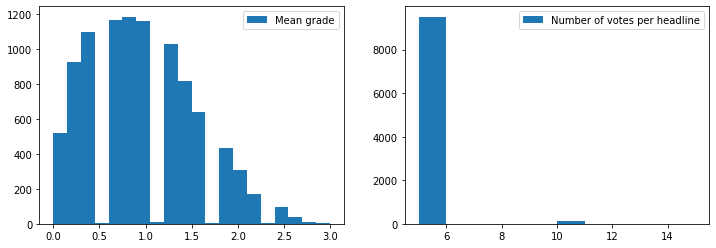

In [ ]:
# Analysis of Original Dataset
# Histogram: How often were the headlines graded and what is the distribution of the scores?
# -> those graded two times or less might be unreliable -> omit from the dataset?

#Count the number of votes

train_df_visual = train_df
train_df_visual['gradeCount'] = train_df_visual['grades'].astype('str').str.len()

#Plot the mean grade and nomber of votes per headline
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(train_df_visual['meanGrade'],  label = 'Mean grade', bins=20)
axs[1].hist(train_df_visual['gradeCount'], label = 'Number of votes per headline')

axs[0].legend()
axs[1].legend()

In [ ]:
# What is considered to be a particularly funny headline? What isn't?
train_df[train_df['meanGrade'] > 2.5].head()

id  ... gradeCount
673   14637  ...          5
898    1664  ...          5
1092   1382  ...          5
1125   8301  ...          5
1290   9933  ...          5

[5 rows x 6 columns]

In [ ]:
train_df[train_df['meanGrade'] < 0.5].head()

id  ... gradeCount
0  14530  ...          5
3     76  ...          5
4   6164  ...          5
8   6554  ...          5
9  14191  ...          5

[5 rows x 6 columns]

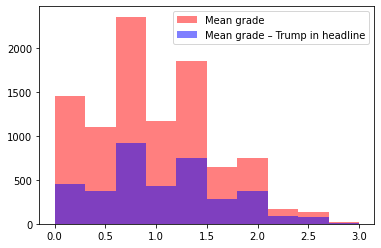

In [ ]:
# Is there a correlation between the funniness of headlines and the appearance of Trump in the title?
# If yes, the voters might be biased towards finding Trump jokes funny

plt.hist(train_df_visual['meanGrade'],  label = 'Mean grade', color=(1,0,0,0.5))
plt.hist(train_df_visual.loc[train_df_visual['original'].str.find('Trump') != -1, 'meanGrade'],  label = 'Mean grade – Trump in headline', color=(0,0,1,0.5))

plt.legend()

There are 9652 headlines in the original corpus
There are 28 headlines to remove for which there is limited consensus on funniness by humans (stdev > 1.4)
There are 9624 headlines in the filtered corpus


id  ...     stdev
849   9397  ...  1.469694
1269   141  ...  1.469694
1299  4526  ...  1.469694
1997  9757  ...  1.469694
2013  9779  ...  1.469694

[5 rows x 6 columns]

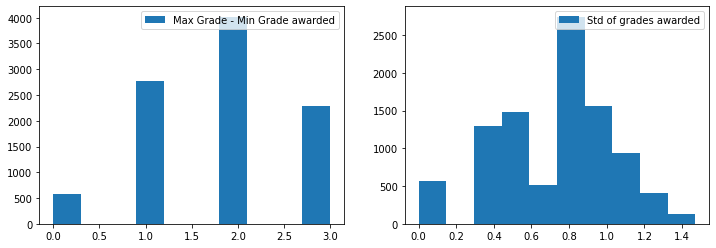

In [ ]:
# Is there consensus among human graders? Filter out 'unreliable' datapoints without human consensus
train_df_stdev = train_df.copy()
std_of_grades = train_df_stdev['grades'].astype('str').apply(lambda x:list(x)).apply(lambda y:np.std([int(i) for i in y]))
range_of_grades = train_df_stdev['grades'].astype('str').apply(lambda x:list(x)).apply(lambda y:max([int(i) for i in y])-min([int(i) for i in y]))


#Plot the std of grades and ranges of grades per headline
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(range_of_grades,  label = 'Max Grade - Min Grade awarded')

axs[1].hist(std_of_grades, label = 'Std of grades awarded')

axs[0].legend()
axs[1].legend()

# Filter remove datapoints from training set if the stdev is > 1.4
train_df["stdev"] = train_df_stdev['grades'].astype('str').apply(lambda x:list(x)).apply(lambda y:np.std([int(i) for i in y]))
print(f"There are {len(train_df)} headlines in the original corpus")
points_to_remove = train_df[train_df['stdev'] > 1.4]
print(f"There are {len(points_to_remove)} headlines to remove for which there is limited consensus on funniness by humans (stdev > 1.4)")


filtered_train_df = train_df[train_df['stdev'] < 1.4]
print(f"There are {len(filtered_train_df)} headlines in the filtered corpus")

display(points_to_remove.head())


In [ ]:
# Vocabulary overlap of train and test data
voc_train, train_tokens = preprocessing(train_df, unk_threshold = -1, start_end_tok = True, merge_headlines = False)
voc_test, test_tokens = preprocessing(final_test_df_w_labels, unk_threshold = -1, start_end_tok = True, merge_headlines = False)

Step 1 (Created edited headline): France is ‘ hunting down its citizens who joined twins ’ without trial in Iraq
Step 2 (Lowercase): france is ‘ hunting down its citizens who joined twins ’ without trial in iraq
Step 3 (Punctuation removal):  france is  hunting down its citizens who joined twins  without trial in iraq
Step 4 (Stopword removal): france hunting citizens joined twins without trial iraq
Step 5 (Stemming): franc hunt citizen join twin without trial iraq
Step 6 (Start & end tokens): <s> franc hunt citizen join twin without trial iraq <\s>
Step 1 (Created edited headline): The Latest : Election tally shows Cars turning right
Step 2 (Lowercase): the latest : election tally shows cars turning right
Step 3 (Punctuation removal):  the latest  election tally shows cars turning right
Step 4 (Stopword removal): latest election tally shows cars turning right
Step 5 (Stemming): latest elect talli show car turn right
Step 6 (Start & end tokens): <s> latest elect talli show car turn rig

25.0 % of the words in the test set are not seen during training!


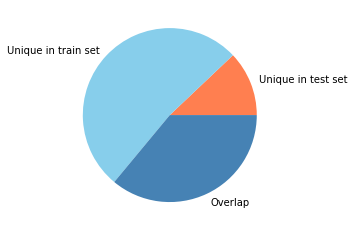

In [ ]:
# How many unseen words are there?

voc = voc_test + voc_train
overlap = 0
unique_test = 0
unique_train = 0

for word in voc_test:
  if word in voc_train:
    overlap += 1
  else: unique_test += 1

for word in voc_train:
  if word not in voc_test:
    unique_train += 1

print(np.round(unique_test*100/len(voc_test)) , "% of the words in the test set are not seen during training!")
fig = plt.pie([unique_test, unique_train, overlap], labels = ["Unique in test set", "Unique in train set", "Overlap"], colors = ['coral', 'skyblue', 'steelblue'])
plt.show(fig)


Maximum number of tokens in a sentence: 18
Minimum number of tokens in a sentence: 4
Mean and stdev of sentence length - mu = 10.05, std = 2.14
Longest sentence: ['<s>', 'chile', 'creat', 'around', '10', 'million', 'acr', 'nation', 'swamp', 'system', 'patagonia', 'support', 'founder', 'north', 'face', 'cloth', 'compani', '<\\s>']
Shortest sentence: ['<s>', 'caveman', 'daca', '<\\s>']


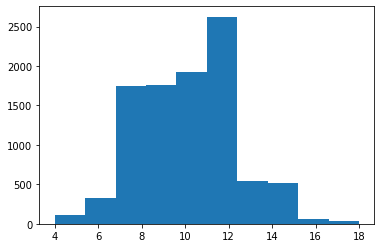

In [ ]:
# What's the max number of words in a sentence in the train set?
voc_train, train_tokens = preprocessing(train_df, unk_threshold = -1, start_end_tok = True, merge_headlines = False, verbose = False)
voc_test, test_tokens = preprocessing(test_df, unk_threshold = -1, start_end_tok = True, merge_headlines = False, verbose = False)

lengths = [len(l) for l in train_tokens]
plt.hist(lengths)
print(f'Maximum number of tokens in a sentence: {max(lengths)}')
print(f'Minimum number of tokens in a sentence: {min(lengths)}')
print(f'Mean and stdev of sentence length - mu = {np.mean(lengths).round(2)}, std = {np.std(lengths).round(2)}')
large_idxs = np.argsort(lengths)
print(f'Longest sentence: {train_tokens[large_idxs[-1]]}')
print(f'Shortest sentence: {train_tokens[large_idxs[0]]}')

# Shared Functions
Both approaches use the following methods:

In [ ]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)
    """

    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.4f} | RMSE: {rmse:.4f} |')

    return sse, mse

In [ ]:
# We define our training loop
def train(train_iter, dev_iter, model, number_epoch, loss_fn, optimizer, scheduler, logging_steps = 0):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    """

    print("Training model.")
    
    if logging_steps > 0:
        schedule_per_step = True
    else:
        schedule_per_step = False
    
    training_losses = []
    validation_losses = []
    start_time = time.time()
    
    steps = 0
    avg_step_loss = 0

    for epoch in range(1, number_epoch+1):

        model.train()
        epoch_loss = 0
        epoch_sse = 0
        no_observations = 0  # Observations used for training so far

        for i, batch in enumerate(train_iter):
            steps += 1
            
            feature, target = batch
            
            target = target.to(device)
            for k, v in feature.items():
                feature[k] = feature[k].to(device)

            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            
            predictions = model(feature).squeeze(1)

            optimizer.zero_grad()

            loss = loss_fn(predictions, target)

            sse, __ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy())

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse
            avg_step_loss += loss.item()
            
            # Record the first loss for comparison to see how much we improved from 'random'
            if epoch == 1 and i == 0:
                epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_sse / no_observations
                valid_loss, valid_mse, __, __ = eval(dev_iter, model, loss_fn)
                training_losses.append(epoch_loss)
                validation_losses.append(valid_loss)
                model.train()
                
            if schedule_per_step:
                
                scheduler.step()
                
                if steps % logging_steps == 0:
                    # Epoch SSE is zeroed at the start of each epoch, so don't use it
                    valid_loss, valid_mse, __, __ = eval(dev_iter, model, loss_fn)
                    step_loss = avg_step_loss / logging_steps
                    print(f'{(time.time()-start_time)/60:.4f} | Steps: {steps:02} | Avg train Loss: {step_loss:.4f} | \
                    Val. Loss: {valid_loss:.4f} |')
                
                    training_losses.append(step_loss)
                    validation_losses.append(valid_loss)
                    # Reset the step loss
                    avg_step_loss = 0
                    
        valid_loss, valid_mse, __, __ = eval(dev_iter, model, loss_fn)
        epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_sse / no_observations
        print(f'{(time.time()-start_time)/60:.4f} | Epoch: {epoch:02} | Train Loss: {epoch_loss:.4f} | Train MSE: {epoch_mse:.4f} | Train RMSE: {epoch_mse**0.5:.4f} | \
        Val. Loss: {valid_loss:.4f} | Val. MSE: {valid_mse:.4f} |  Val. RMSE: {valid_mse**0.5:.4f} |')
        
        if not schedule_per_step:
            scheduler.step()

            training_losses.append(epoch_loss)
            validation_losses.append(valid_loss)

    return training_losses, validation_losses

In [ ]:
# We evaluate performance on our dev set
def eval(data_iter, model, loss_fn):
    """
    Evaluating model performance on the dev set
    """
    model.eval()
    epoch_loss = 0
    epoch_sse = 0
    pred_all = []
    trg_all = []
    no_observations = 0

    with torch.no_grad():
        for batch in data_iter:
            feature, target = batch

            target = target.to(device)
            for k, v in feature.items():
                feature[k] = feature[k].to(device)

            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            
            predictions = model(feature).squeeze(1)
            
            loss = loss_fn(predictions, target)

            # We get the mse
            pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
            sse, __ = model_performance(pred, trg)

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse
            pred_all.extend(pred)
            trg_all.extend(trg)

    return epoch_loss/no_observations, epoch_sse/no_observations, np.array(pred_all), np.array(trg_all)

In [ ]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)
    """
    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.4f} | RMSE: {rmse:.4f} |')

    return sse, mse

In [ ]:
def rmse(predictions, labels):
    loss = torch.sqrt(((predictions - labels)**2).mean())
    return loss

# Approach 1

We implemented a BiLSTM and Transformer model.

## Model 1: BiLSTM

In [ ]:
# Get Glove
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-03-01 16:10:27--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-01 16:10:27--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-01 16:10:28--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
class BiLSTM(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, batch_size, pretrained_embeddings, num_lstm_layers = 1, ffnn_layers = [20], freeze_embedding = True, dropout = 0.5, combination = 'concat'):
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size
        self.num_lstm_layers = num_lstm_layers
        assert combination in ['concat', 'mult', 'subtract', 'edited_only']
        self.combination = combination
        
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=freeze_embedding, padding_idx=0)
            
        self.dropout = nn.Dropout(dropout)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers = num_lstm_layers, bidirectional=True) 
        
        # The linear layer that maps from hidden state space to tag space
        # Double the hidden dimension since we're bidirectional
        # (Separate context vectors from the forward and backward passes)
        # And double again because we're passing in two sentences (original and edited)  
        
        # Loop through layers and create network
        if combination == 'concat' or combination == 'edited_only':
            if combination == 'concat':
                lstm_final_dim = hidden_dim * 4
            else:
                lstm_final_dim = hidden_dim * 2
            layer_dims = [lstm_final_dim, *ffnn_layers, 1]
            layers = []
            for i, (input_dim, output_dim) in enumerate(zip(layer_dims, layer_dims[1:])):
                layers.append(torch.nn.Dropout(dropout))
                layers.append(torch.nn.Linear(input_dim, output_dim))
                if i < len(ffnn_layers):
                    layers.append(torch.nn.ReLU())
                else:
                    layers.append(torch.nn.Sigmoid())
            self.classify = torch.nn.Sequential(*layers)
        else:
            self.classify1 = nn.Sequential(
                nn.Dropout(dropout),
                nn.Linear(hidden_dim * 2, ffnn_layers[0]),
                nn.ReLU()
            )
            self.classify2 = nn.Sequential(
                nn.Dropout(dropout),
                nn.Linear(ffnn_layers[0], 1),
                nn.Sigmoid()
            )

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly why they have this dimensionality.
        # The axes semantics are (num_layers * num_directions, minibatch_size, hidden_dim)
        self.hidden_o = torch.zeros(self.num_lstm_layers * 2, self.batch_size, self.hidden_dim).to(device), torch.zeros(self.num_lstm_layers * 2, self.batch_size, self.hidden_dim).to(device)
        self.hidden_e = torch.zeros(self.num_lstm_layers * 2, self.batch_size, self.hidden_dim).to(device), torch.zeros(self.num_lstm_layers * 2, self.batch_size, self.hidden_dim).to(device)

    def forward(self, sentences):
        embedded_o = self.dropout(self.embedding(sentences['original']))
        embedded_e = self.dropout(self.embedding(sentences['edited']))
        
        # We were [batch, tokens, embedding dims]
        # Switch to [tokens, batch, embedding dims] for LSTM
        embedded_o = embedded_o.permute(1, 0, 2)
        embedded_e = embedded_e.permute(1, 0, 2)
        
        # Set hidden layers to 0
        self.init_hidden()
        
        lstm_out_o, self.hidden_o = self.lstm(embedded_o, self.hidden_o)
        lstm_out_e, self.hidden_e = self.lstm(embedded_e, self.hidden_e)
        
        # Get just the hidden state (not the cell state)
        self.hidden_o = self.hidden_o[0]
        self.hidden_e = self.hidden_e[1]
        
        # Concatenate forwards and backwards directions
        out_o = torch.cat((self.hidden_o[0, :, :], self.hidden_o[1, :, :]), dim=-1)
        out_e = torch.cat((self.hidden_e[0, :, :], self.hidden_e[1, :, :]), dim=-1)
        
        if self.combination == 'concat':
            out = torch.cat((out_o, out_e), dim=-1)
            out = self.classify(out) * 3
            
        elif self.combination == 'edited_only':
            out = self.classify(out_e) * 3
            
        elif self.combination == 'mult':
            out_o = self.classify1(out_o)
            out_e = self.classify1(out_e)
            out = out_o * out_e
            out = self.classify2(out) * 3
        else:
            out_o = self.classify1(out_o)
            out_e = self.classify1(out_e)
            out = out_e - out_o
            out = self.classify2(out) * 3
        
        return out

In [ ]:
class gloveDataset(Dataset):

    def __init__(self, tokenizer, train_df):
        self.tokenizer = tokenizer
        self.y_train = train_df['meanGrade']
        original = self.tokenise(self.original_sentences(train_df))
        edited = self.tokenise(self.edited_sentences(train_df))
        self.x_train = list(zip(original, edited))

    def edited_sentences(self, df):
        edited_sentences = []
        for index, row in df.iterrows():
            edited_sentences.append(re.sub('<.*\/>', row['edit'], row['original']))
        return edited_sentences
    
    def original_sentences(self, df):
        original_sentences = []
        for index, row in df.iterrows():
            original_word = ''.join(re.findall('<(.*)\/>', row['original']))
            original_sentences.append(re.sub('<.*\/>', original_word, row['original']))
        return original_sentences
    
    def collate_fn_padd(self, batch):
        '''
        We add padding to our minibatches and create tensors for our model
        '''
        batch_features_o = [f[0] for f, l in batch]
        batch_features_e = [f[1] for f, l in batch]
        batch_labels = [l for f, l in batch]

        if len(batch_features_o) != len(batch_features_e):
            print('ERROR! Original and edited batch lengths different')

        dict_tensor = {}
        dict_tensor['original'] = self.add_padding(batch_features_o)
        dict_tensor['edited'] = self.add_padding(batch_features_e)

        batch_labels = torch.FloatTensor(batch_labels)

        return dict_tensor, batch_labels
            
    def add_padding(self, features):
        features_len = [len(f) for f in features]
            
        seq_tensor = torch.zeros((len(features), max(features_len))).long()

        for idx, (seq, seqlen) in enumerate(zip(features, features_len)):
            seq_tensor[idx, :seqlen] = torch.LongTensor(seq)
            
        return seq_tensor
    
    def tokenise(self, features):
        batch_idxs = []
        for sentence in features:
            sentence_idxs = []
            # Add spaces to each side of accepted punctuation
            sentence = sentence.replace(".", " . ").replace(",", " , ").replace(";", " ; ").replace("?", " ? ")
            # Split on spaces
            sentence = sentence.lower().split()
            # Get glove index if it exists, otherwise discard
            for w in sentence:
                if w in self.tokenizer.stoi:
                    sentence_idxs.append(self.tokenizer.stoi[w])
                else:
                    # Replace hyphen with a space and see if we match
                    new_phrase = w.replace("-", " ")
                    new_phrase = new_phrase.split()
                    for new_w in new_phrase:
                        if new_w in self.tokenizer.stoi:
                            sentence_idxs.append(self.tokenizer.stoi[new_w])                    
            batch_idxs.append(sentence_idxs)
        return batch_idxs

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        return self.x_train[item], self.y_train[item]

In [ ]:
k_folds = 2             # Number of folds to run for the parameter set
embedding_dim = 100     # Number of dimensions for GloVe representations. Can be [50, 100, 200, 300]
hidden_dim = 50         # Number of dimensions within the RNN
batch_size = 16         # Batch size
epochs = 30             # Number of epochs
lr = 0.001              # Initial learning rate for the classification layer
lr_embedding = 0        # Learning rate for the pre-trained embedding. 0 => freeze the embedding.
ffnn_layers = [20]      # Hidden layers and number of neurons in classification layer.  [] is no hidden layer. [20 20] is two layers both with 20 neurons.
num_lstm_layers = 1     # Number of stacked LSTMs
combo = 'edited_only'   # How to combine the data.  Can be [edited_only', 'concat', 'mult', 'subtract']
train_data = train_df   # Data to use for train split
test_data = None        # Data to use for test split.  If none, model will do train_test_split on the train_data.

k_train_losses = []
k_val_losses = []
    
train_losses = []
val_losses = []

if lr_embedding == 0:
    freeze = True

for k in range(k_folds):
    print()

    # Initialise glove
    glove = torchtext.vocab.GloVe(name="6B", dim=embedding_dim)

    
    train_split_df, dev_df = train_test_split(train_df, test_size=0.2, random_state=42)
    train_split_df.reset_index(inplace = True)
    dev_df.reset_index(inplace = True)
    train_dataset = gloveDataset(glove, train_split_df)
    dev_dataset = gloveDataset(glove, dev_df)
    
    # Initialise datasets
    if test_data is None:
        train_split_df, dev_df = train_test_split(train_data, test_size=0.2, random_state=42)
        train_split_df.reset_index(inplace = True)
        dev_df.reset_index(inplace = True)
        train_dataset = gloveDataset(glove, train_split_df)
        dev_dataset = gloveDataset(glove, dev_df)
    else:
        train_dataset = gloveDataset(glove, train_data)
        dev_dataset = gloveDataset(glove, test_data)

    # Initialise model
    model = BiLSTM(embedding_dim, hidden_dim, batch_size, glove.vectors, num_lstm_layers = num_lstm_layers, ffnn_layers = ffnn_layers, combination = combo, freeze_embedding = freeze)
    model.to(device)

    print(f'Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

    # Create dataloaders
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size, collate_fn=train_dataset.collate_fn_padd)
    dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=batch_size, collate_fn=dev_dataset.collate_fn_padd)

    # Set loss function
    loss_fn = rmse

    params = [
        {'params': [p for n, p in model.named_parameters() if "embedding" in n], 'lr': lr_embedding},
        {'params': [p for n, p in model.named_parameters() if "embedding" not in n]}
    ]
    optimizer = torch.optim.AdamW(params, lr=lr, eps = 1e-8)
    lambda_scheduler = lambda epoch: 0.98 ** epoch
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_scheduler)

    t_loss, v_loss = train(train_loader, dev_loader, model, epochs, loss_fn, optimizer, scheduler)
    #torch.save(model.state_dict(), f'model_{i}.pickle')

    train_losses.append(t_loss)
    val_losses.append(v_loss)

k_train_losses.append(train_losses)
k_val_losses.append(val_losses)
    
'''with open('rnn_final_run.pickle', 'wb') as f:
    pickle.dump((k_train_losses, k_val_losses), f)'''


Number of trainable parameters: 62841
Training model.
0.20 | Epoch: 01 | Train Loss: 0.62 | Train MSE: 0.39 | Train RMSE: 0.63 |         Val. Loss: 0.57 | Val. MSE: 0.34 |  Val. RMSE: 0.58 |
0.38 | Epoch: 02 | Train Loss: 0.59 | Train MSE: 0.36 | Train RMSE: 0.60 |         Val. Loss: 0.57 | Val. MSE: 0.34 |  Val. RMSE: 0.58 |
0.56 | Epoch: 03 | Train Loss: 0.58 | Train MSE: 0.35 | Train RMSE: 0.59 |         Val. Loss: 0.57 | Val. MSE: 0.33 |  Val. RMSE: 0.58 |
0.74 | Epoch: 04 | Train Loss: 0.58 | Train MSE: 0.34 | Train RMSE: 0.59 |         Val. Loss: 0.57 | Val. MSE: 0.34 |  Val. RMSE: 0.58 |
0.92 | Epoch: 05 | Train Loss: 0.57 | Train MSE: 0.33 | Train RMSE: 0.58 |         Val. Loss: 0.56 | Val. MSE: 0.32 |  Val. RMSE: 0.57 |
1.10 | Epoch: 06 | Train Loss: 0.56 | Train MSE: 0.33 | Train RMSE: 0.57 |         Val. Loss: 0.55 | Val. MSE: 0.31 |  Val. RMSE: 0.56 |
1.28 | Epoch: 07 | Train Loss: 0.56 | Train MSE: 0.32 | Train RMSE: 0.57 |         Val. Loss: 0.55 | Val. MSE: 0.31 |  Val.

"with open('rnn_final_run.pickle', 'wb') as f:\n    pickle.dump((k_train_losses, k_val_losses), f)"

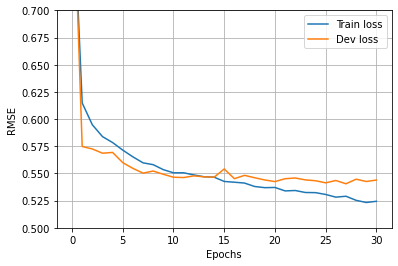

In [ ]:
# Plot average results for each fold
'''with open('rnn_final_run.pickle', 'rb') as f:
    k_train_losses, k_val_losses = pickle.load(f)'''

k_train_losses_np = np.array(k_train_losses)
k_val_losses_np = np.array(k_val_losses)

k_train_losses_np = k_train_losses_np.mean(axis=1)
k_val_losses_np = k_val_losses_np.mean(axis=1)

fig, ax = plt.subplots()
ax.plot(k_train_losses_np[0,:], label='Train loss')
ax.plot(k_val_losses_np[0,:], label='Dev loss')
ax.grid()
ax.legend()
ax.set_xlabel(f'Epochs')
ax.set_ylabel(f'RMSE')
ax.set_ylim([0.5, 0.7])
fig.savefig('rnn_final_model.png')

## Model 2: Transformer

In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

     |████████████████████████████████| 1.9MB 18.3MB/s 
     |████████████████████████████████| 890kB 56.1MB/s 
     |████████████████████████████████| 3.2MB 45.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=b671709332a8b2383d482f12ee19925704f9d5b93fb3f21eec7b3a3c31d16d11
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 1.2MB 18.7MB/s 
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [ ]:
from transformers import Trainer, TrainingArguments
from transformers import BertTokenizer
from transformers import BertPreTrainedModel, BertModel
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from transformers import ElectraTokenizer, ElectraModel, ElectraPreTrainedModel

In [ ]:
class PreTrainedDataset(Dataset):

    def __init__(self, tokenizer, df, combination = 'concat'):
        assert combination in ['concat', 'sep', 'edited_only']
        
        self.tokenizer = tokenizer
        self.y_train = df['meanGrade']
        self.combination = combination
        
        original = self.original_sentences(df)
        edited = self.edited_sentences(df)
        self.x_train = list(zip(original, edited))

    def edited_sentences(self, df):
        edited_sentences = []
        for index, row in df.iterrows():
            edited_sentences.append(re.sub('<.*\/>', row['edit'], row['original']))
        return edited_sentences
    
    def original_sentences(self, df):
        original_sentences = []
        for index, row in df.iterrows():
            original_word = ''.join(re.findall('<(.*)\/>', row['original']))
            original_sentences.append(re.sub('<.*\/>', original_word, row['original']))
        return original_sentences
 
    def collate_fn(self, batch):
        batch_features_o = [f[0] for f, l in batch]
        batch_features_e = [f[1] for f, l in batch]
        batch_labels = [l for f, l in batch]

        batch_labels = torch.FloatTensor(batch_labels)
        
        dict_tensor = {}
        if self.combination == 'edited_only' or self.combination == 'concat':
            dict_tensor['edited'] = self.tokenizer(batch_features_e, return_tensors='pt', padding=True, truncation=True, max_length=128)
        elif self.combination == 'sep':
            dict_tensor['both'] = self.tokenizer(batch_features_o, batch_features_e, return_tensors='pt', padding=True, truncation=True, max_length=256)
        if self.combination == 'concat':
            dict_tensor['original'] = self.tokenizer(batch_features_o, return_tensors='pt', padding=True, truncation=True, max_length=128)

        return dict_tensor, batch_labels

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        return self.x_train[item], self.y_train[item]

In [ ]:
class BERT_regression(BertPreTrainedModel):

    def __init__(self, config, ffnn_layers = [20], dropout = 0.5, combination = 'concat'):
        super().__init__(config)

        # BERT Model
        self.bert = BertModel(config)
        
        assert combination in ['concat', 'sep', 'edited_only']
        self.combination = combination
        
        if combination == 'concat':
            final_dim = 2 * config.hidden_size
        else:
            final_dim = config.hidden_size
        layer_dims = [final_dim, *ffnn_layers, 1]
        layers = []
        for i, (input_dim, output_dim) in enumerate(zip(layer_dims, layer_dims[1:])):
            layers.append(torch.nn.Dropout(dropout))
            layers.append(torch.nn.Linear(input_dim, output_dim))
            if i < len(ffnn_layers):
                layers.append(torch.nn.ReLU())
            else:
                layers.append(torch.nn.Sigmoid())
        self.classify = torch.nn.Sequential(*layers)

        self.init_weights()

    def forward(self, inputs):
        
        data2 = None
        
        if self.combination == 'edited_only':
            data1 = inputs['edited']
        elif self.combination == 'sep':
            data1 = inputs['both']
        elif self.combination == 'concat':
            data1 = inputs['original']
            data2 = inputs['edited']
        
        outputs1 = self.bert(input_ids = data1['input_ids'], attention_mask = data1['attention_mask'], token_type_ids=data1['token_type_ids'])
        
        if data2 is not None:
            outputs2 = self.bert(input_ids = data2['input_ids'], attention_mask = data2['attention_mask'], token_type_ids=data2['token_type_ids'])
            outputs = torch.cat((outputs1[1], outputs2[1]), dim=-1)
        else:
            outputs = outputs1[1]
        
        out = self.classify(outputs)
        out = out * 3
        
        return out

In [ ]:
class Electra_regression(ElectraPreTrainedModel):

    def __init__(self, config, ffnn_layers = [20], dropout = 0.5, combination = 'concat'):
        super().__init__(config)

        # Electra Model
        self.electra = ElectraModel(config)
        
        assert combination in ['concat', 'sep', 'edited_only']
        self.combination = combination
        
        if combination == 'concat':
            final_dim = 2 * config.hidden_size
        else:
            final_dim = config.hidden_size
        layer_dims = [final_dim, *ffnn_layers, 1]
        layers = []
        for i, (input_dim, output_dim) in enumerate(zip(layer_dims, layer_dims[1:])):
            layers.append(torch.nn.Dropout(dropout))
            layers.append(torch.nn.Linear(input_dim, output_dim))
            if i < len(ffnn_layers):
                layers.append(torch.nn.GELU())
            else:
                layers.append(torch.nn.Sigmoid())
        self.classify = torch.nn.Sequential(*layers)

        self.init_weights()

    def forward(self, inputs):
        
        data2 = None
        
        if self.combination == 'edited_only':
            data1 = inputs['edited']
        elif self.combination == 'sep':
            data1 = inputs['both']
        elif self.combination == 'concat':
            data1 = inputs['original']
            data2 = inputs['edited']
        
        outputs1 = self.electra(input_ids = data1['input_ids'], attention_mask = data1['attention_mask'], token_type_ids=data1['token_type_ids'])
        
        if data2 is not None:
            outputs2 = self.electra(input_ids = data2['input_ids'], attention_mask = data2['attention_mask'], token_type_ids=data2['token_type_ids'])
            outputs = torch.cat((outputs1[0][:, 0, :], outputs2[0][:, 0, :]), dim=-1)
        else:
            outputs = outputs1[0][:, 0, :]
        
        out = self.classify(outputs)
        out = out * 3
        
        return out

In [ ]:
def initialise_optimizers(model, num_epochs, lr_bert = 0.00005, lr_regression = 0.001, base_model_name = 'bert'):
    # As per hugging face tutorial (https://huggingface.co/transformers/training.html) could choose not to apply weight decay to bias or layer norm weights
    # TODO: link
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if base_model_name not in n], 'lr': lr_regression},
        {'params': [p for n, p in model.named_parameters() if base_model_name in n]}
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=lr_bert, eps = 1e-8)

    total_steps = (len(train_dataset)/batch_size) * num_epochs
    warm_up_steps = int(total_steps * 0.3)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = warm_up_steps, num_training_steps = total_steps)

    return optimizer, scheduler

In [ ]:
k_folds = 1             # Number of folds to run for the parameter set
batch_size = 16         # Batch size
epochs = 2              # Number of epochs
lr_regression = 0.001   # Initial learning rate for the classification layer
lr_bert = 0.00005       # Learning rate for the transformer
dropout = 0.5           # Amount of dropout on the classification layers
combo = 'sep'           # How to combine the data.  Can be ['sep', 'edited_only', 'concat']
base_model = 'electra'  # Which base model to use.  Can be ['bert', 'electra']
save_name = 'electra_all_train_df'  # Filename to save the model to (commented out in the code below)

train_data = train_df               # Data to use for train split
test_data = final_test_df_w_labels  # Data to use for test split.  If none, model will do train_test_split on the train_data.

k_train_losses = []
k_val_losses = []

# Commented out for loop that's used for running grid-search on parameters
#combo_list = ['concat', 'sep', 'edited_only']
#for combo in combo_list:
#    print(combo)

train_losses = []
val_losses = []
for k in range(k_folds):
    print()
    print(f'Running fold {k}')
    
    if base_model == 'bert':
        tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
    elif base_model == 'electra':
        tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')

    if test_data is None:
        train_split_df, dev_df = train_test_split(train_data, test_size=0.2, random_state=k)
        train_split_df.reset_index(inplace = True)
        dev_df.reset_index(inplace = True)
        train_dataset = PreTrainedDataset(tokenizer, train_split_df, combination = combo)
        dev_dataset = PreTrainedDataset(tokenizer, dev_df, combination = combo)
    else:
        train_dataset = PreTrainedDataset(tokenizer, train_data, combination = combo)
        dev_dataset = PreTrainedDataset(tokenizer, test_data, combination = combo)

    # Initialise model
    if base_model == 'bert':
        model = BERT_regression.from_pretrained("bert-base-cased", combination = combo, dropout = dropout)
    elif base_model == 'electra':
        model = Electra_regression.from_pretrained("google/electra-base-discriminator", combination = combo, dropout = dropout)
    model.to(device)

    print(f'Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

    # Create dataloaders
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size, collate_fn=train_dataset.collate_fn)
    dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=batch_size, collate_fn=dev_dataset.collate_fn)

    # Set loss function
    loss_fn = rmse

    optimizer, scheduler = initialise_optimizers(model, epochs, lr_bert, lr_regression, base_model_name = base_model)

    t_loss, v_loss = train(train_loader, dev_loader, model, epochs, loss_fn, optimizer, scheduler, logging_steps = 100)
    # torch.save(model.state_dict(), f'{save_name}_model_{i}.pickle')

    train_losses.append(t_loss)
    val_losses.append(v_loss)

k_train_losses.append(train_losses)
k_val_losses.append(val_losses)
    
#with open(f'{save_name}.pickle', 'wb') as f:
#    pickle.dump((k_train_losses, k_val_losses), f)


Running fold 0


Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing Electra_regression: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing Electra_regression from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Electra_regression from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Electra_regression were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classify.1.weight', 'classify.1.bias', 'classify.4.weight', 'classif

Number of trainable parameters: 108907049
Training model.
0.7440 | Steps: 100 | Avg train Loss: 0.6828 |                     Val. Loss: 0.5772 |
1.3030 | Steps: 200 | Avg train Loss: 0.5608 |                     Val. Loss: 0.5673 |
1.8601 | Steps: 300 | Avg train Loss: 0.5808 |                     Val. Loss: 0.5765 |
2.4232 | Steps: 400 | Avg train Loss: 0.5745 |                     Val. Loss: 0.5623 |
2.9727 | Steps: 500 | Avg train Loss: 0.5617 |                     Val. Loss: 0.5347 |
3.5361 | Steps: 600 | Avg train Loss: 0.5476 |                     Val. Loss: 0.5245 |
3.7478 | Epoch: 01 | Train Loss: 0.5839 | Train MSE: 0.3536 | Train RMSE: 0.5947 |         Val. Loss: 0.5367 | Val. MSE: 0.2950 |  Val. RMSE: 0.5432 |
4.2977 | Steps: 700 | Avg train Loss: 0.5243 |                     Val. Loss: 0.5389 |
4.8524 | Steps: 800 | Avg train Loss: 0.4908 |                     Val. Loss: 0.5319 |
5.4137 | Steps: 900 | Avg train Loss: 0.4791 |                     Val. Loss: 0.5327 |
5.9770 |

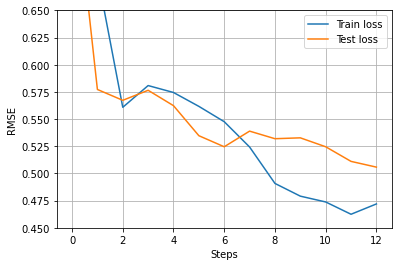

In [ ]:
# Plot average results for each fold
k_train_losses_np = np.array(k_train_losses)
k_val_losses_np = np.array(k_val_losses)

k_train_losses_np = k_train_losses_np.mean(axis=1)
k_val_losses_np = k_val_losses_np.mean(axis=1)

fig, ax = plt.subplots()
ax.plot(k_train_losses_np[0,:], label='Train loss')
ax.plot(k_val_losses_np[0,:], label='Test loss')
ax.grid()
ax.legend()
ax.set_xlabel(f'Steps')
ax.set_ylabel(f'RMSE')
ax.set_ylim([0.45, 0.65])

fig.savefig('train_df_electra.png')


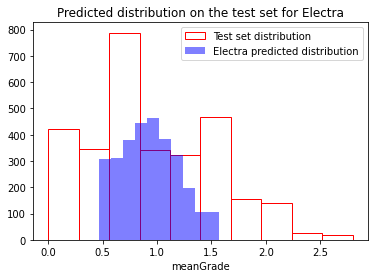

In [ ]:
model.eval()
pred_all = []

with torch.no_grad():
    for batch in dev_loader:
        feature, target = batch

        target = target.to(device)
        for k, v in feature.items():
            feature[k] = feature[k].to(device)

        predictions = model(feature).squeeze(1)
        pred = predictions.detach().cpu().numpy()
        pred_all.extend(pred)

plt.hist(final_test_df_w_labels["meanGrade"], label="Test set distribution", color=(1,1,1, 0), edgecolor="r")
plt.hist(pred_all, label="Electra predicted distribution", color=(0,0,1,0.5))
plt.legend()
plt.title("Predicted distribution on the test set for Electra")
plt.xlabel("meanGrade")

import json
with open("electra_results.json", "w") as f:
    json.dump({"predictions": [float(p) for p in pred_all]}, f, indent=3)

# Approach 2: No pre-trained representations

#### Baseline Model
Linear regression model trained on the tf-idf encoded edited word.

In [ ]:
train_and_dev = train_df['edit']

train_proportion = 0.8

training_data, dev_data, training_y, dev_y = train_test_split(train_df['edit'], train_df['meanGrade'],
                                                                        test_size=(1-train_proportion),
                                                                        random_state=42)

# We train a Tf-idf model
count_vect = CountVectorizer(stop_words='english')
train_counts = count_vect.fit_transform(training_data)
transformer = TfidfTransformer().fit(train_counts)
train_counts = transformer.transform(train_counts)
regression_model = LinearRegression().fit(train_counts, training_y)

# Train predictions
predicted_train = regression_model.predict(train_counts)

# Calculate Tf-idf using train and dev, and validate model on dev:
test_and_test_counts = count_vect.transform(train_and_dev)
transformer = TfidfTransformer().fit(test_and_test_counts)

test_counts = count_vect.transform(dev_data)

test_counts = transformer.transform(test_counts)

# Dev predictions
predicted = regression_model.predict(test_counts)

# We run the evaluation:
print("\nTrain performance:")
sse, mse = model_performance(predicted_train, training_y, True)

print("\nDev performance:")
sse, mse = model_performance(predicted, dev_y, True)


Train performance:
| MSE: 0.13 | RMSE: 0.37 |

Dev performance:
| MSE: 0.36 | RMSE: 0.60 |


**Baseline for task 2**

In [ ]:
# Baseline for the task
pred_baseline = torch.zeros(len(dev_y)) + np.mean(training_y)
print("\nBaseline performance:")
sse, mse = model_performance(pred_baseline, dev_y, True)


Baseline performance:
| MSE: 0.34 | RMSE: 0.58 |


#### Preprocessing Pipeline

In [ ]:
# Decide what pre-processing steps you want


def create_edited_headline(df, add_original_word = False):
    '''
    Creates the edited headline and appends it to the dataframe. 
    Optional: Adds a column with the original word to the dataframe.
    '''

    df = df.copy()
    edited_sentences = []
    for index, row in df.iterrows():
         edited_sentences.append(re.sub('<.*\/>', row['edit'], row['original']))
    if add_original_word:
        df['original_word'] = train_df['original'].astype(str).apply(lambda x: "".join(str(re.findall(r"<(.*)\/>", x)))) #+" "+ train_df["edit"]"".join
  
    df['edited_headline'] = edited_sentences
    return df


def preprocess_dataframe(df_prep, lower_case = True, punctuation = True, stopwords_removal = True, stemming = True, start_end_tok = False, merge_headlines=False, original_word = False):
  
    '''
    Takes a dataframe as input and performs the chosen NLP preprocessing steps on the headlines
    - Lower case letters
    - Punctiation removal
    - stopword remocal
    - stemming
    - start and end tokens
    - merging the original and edited headline
    '''
  
    if "edited_headline" not in df_prep.columns:
        df_prep = create_edited_headline(df_prep, original_word)
    # returns dataframe after preprocessing
        
    # Step 1: Lowercase letters
    if lower_case:
        df_prep['original'] = df_prep['original'].str.lower()
        df_prep['edited_headline'] = df_prep['edited_headline'].str.lower()
        if original_word:
            df_prep['original_word'] = df_prep['original_word'].str.lower()
            df_prep['edit'] = df_prep['edit'].str.lower()
        print("Step 1 (Lowercase):", df_prep['edited_headline'][0])

    # Step 2: Replace punctuation with space
    if punctuation:
        df_prep['original'] = df_prep['original'].str.replace(r"[^\w\s]", "")
        df_prep['edited_headline'] = df_prep['edited_headline'].str.replace(r"[^\w\s]", "")
        if original_word:
            df_prep['original_word'] = df_prep['original_word'].str.replace(r"[^\w\s]", "")
            df_prep['edit'] = df_prep['edit'].str.replace(r"[^\w\s]", "")
        print("Step 2 (Punctuation removal): ", df_prep['edited_headline'][0])

    #Step 3: Stop word removal
    if stopwords_removal:
        stopWords = set(stopwords.words("english"))
        # print(stopWords)
        df_prep['original'] = df_prep['original'].apply(lambda x: " ".join([i for i in x.split() if i not in stopWords]))
        df_prep['edited_headline'] = df_prep['edited_headline'].apply(lambda x: " ".join([i for i in x.split() if i not in stopWords]))
        
        print("Step 3 (Stopword removal):", df_prep['edited_headline'][0])

    # Step 4: Stemming
    if stemming:
        porter = PorterStemmer()
        df_prep['original'] = df_prep['original'].apply(lambda x: " ".join([porter.stem(word) for word in x.split()]))
        df_prep['edited_headline'] = df_prep['edited_headline'].apply(lambda x: " ".join([porter.stem(word) for word in x.split()])) 
        if original_word:
            df_prep['original_word'] = df_prep['original_word'].apply(lambda x: " ".join([porter.stem(word) for word in x.split()])) 
            df_prep['edit'] = df_prep['edit'].apply(lambda x: " ".join([porter.stem(word) for word in x.split()])) 

        print("Step 4 (Stemming):", df_prep['edited_headline'][0])


    # Step 5: Add start and end tokens
    if start_end_tok:
        df_prep['original'] = df_prep['original'].apply(lambda x: "<s> "+ x+ " <\s>")
        df_prep['edited_headline'] = df_prep['edited_headline'].apply(lambda x: "<s> "+ x+ " <\s>")
        
        print("Step 5 (Start & end tokens):", df_prep['edited_headline'][0])


    # Step 6: Merge original and edited headline
    if merge_headlines:
        df_prep['edited_headline'] = df_prep['original'] +' '+ df_prep["edited_headline"]
        print("Step 6 (Merge):", df_prep['edited_headline'][0])

    return df_prep



def enrich_headline_data(prep_funny_headlines, added_headlines, verbose = False):
    '''
    Takes a dataframe of preprocessed funny headlines and a dataframe of unprocessesd additional headlines as input.
    Outputs the concatenated headlines which van be used to train W2V and language models.
    '''
    added_headlines = added_headlines.str.lower()
    added_headlines = added_headlines.str.replace(r"[^\w\s]", "")
    stopWords = set(stopwords.words("english"))
    added_headlines = added_headlines.apply(lambda x: " ".join([i for i in x.split() if i not in stopWords]))
    porter = PorterStemmer()
    added_headlines = added_headlines.apply(lambda x: " ".join([porter.stem(word) for word in x.split()]))
    added_headlines = added_headlines.apply(lambda x: "<s> "+ x+ " <\s>")

    large_headline_corpus = pd.concat([prep_funny_headlines, added_headlines])
    
    if verbose:
        print('Incresed size of input data to', len(large_headline_corpus))
    
    return large_headline_corpus


def create_vocab(data):
    """
    Creating a corpus of all the tokens used based on the data frame (1 column only)
    """
    # Create tokenised_corpus
    tokenised_corpus = [] 
    for sentence in data:
        tokenised_sentence = []
        for token in sentence.split(' '): 
            tokenised_sentence.append(token)
        tokenised_corpus.append(tokenised_sentence)

    # Create vocab list
    vocabulary = [] 
    for sentence in tokenised_corpus:
        for token in sentence:
            if token not in vocabulary:
                if True:
                    vocabulary.append(token)

    return vocabulary, tokenised_corpus



def rare_words_removal(tokenised_corpus, unk_threshold, dataframe=None, replace_in_dataframe = False, verbose = False):

    flat_list = [item for sublist in tokenised_corpus for item in sublist]
    word2count = Counter(flat_list)
    print("Done with count!")

    to_be_unked = dict(filter(lambda elem: elem[1] <= unk_threshold, word2count.items()))
    
    tokenised_corpus = [["<UNK>" if token in to_be_unked else token for token in headline] for headline in tokenised_corpus] 

    if replace_in_dataframe:
        dataframe['edit'] = ["<UNK>" if token in to_be_unked else token for token in dataframe['edit']]
        dataframe['original_word'] = ["<UNK>" if token in to_be_unked else token for token in dataframe['original_word']]
        
        return tokenised_corpus, dataframe
    
    else:
        return tokenised_corpus



#### BoW



In [ ]:
# Experimenting with BagofWords representations of the WHOLE edited headline rather than just the edit word

# pre-process (stemming and stopwords, punctuation removal + lowercase)
train_and_dev = preprocess_dataframe(train_df.copy(), stopwords_removal=True, stemming=True, original_word=True)
vocab, tokenised_corpus = create_vocab(train_and_dev["edited_headline"])

# split out a development set
train_proportion = 0.8
training_data, dev_data, training_y, dev_y = train_test_split(train_and_dev["edited_headline"], train_and_dev['meanGrade'],
                                                                        test_size=(1-train_proportion),
                                                                     random_state=42)
# We train a Tf-idf model using unigrams, bigrams and tri-grams in the bag of words vocab
bigrams = [(1,1), (1,2), (1,3)]
results = []
for bigram in bigrams:

  print(f"n-gram: {bigram}")
  count_vect = CountVectorizer(stop_words="english", ngram_range=bigram)
  train_counts = count_vect.fit_transform(training_data)
  print("Vocabulary with counts", count_vect.vocabulary_)
  print("Length of vocab", len(count_vect.vocabulary_))
  transformer = TfidfTransformer().fit(train_counts)
  train_counts = transformer.transform(train_counts)
  regression_model = LinearRegression().fit(train_counts, training_y)

  # Train predictions
  predicted_train = regression_model.predict(train_counts)*3

  # Calculate Tf-idf using train and dev, and validate model on dev:
  test_and_test_counts = count_vect.transform(train_and_dev)
  transformer = TfidfTransformer().fit(test_and_test_counts)

  test_counts = count_vect.transform(dev_data)

  test_counts = transformer.transform(test_counts)

  # Dev predictions
  predicted = regression_model.predict(test_counts)

  # We run the evaluation:
  print("\nTrain performance:")
  sse_train, mse_train = model_performance(predicted_train, training_y, True)

  print("\nDev performance:")
  sse, mse = model_performance(predicted, dev_y, True)

  results.append({"bigram": bigram, "sse train": round(sse_train,2), "mse train": round(mse_train,2), "sse dev": round(sse,2), "mse dev": round(mse,2), "vocal_len":len(count_vect.vocabulary_) })

Step 1 (Lowercase): france is ‘ hunting down its citizens who joined twins ’ without trial in iraq
Step 2 (Punctuation removal):  france is  hunting down its citizens who joined twins  without trial in iraq
Step 3 (Stopword removal): france hunting citizens joined twins without trial iraq
Step 4 (Stemming): franc hunt citizen join twin without trial iraq
n-gram: (1, 1)
Vocabulary with counts {'robert': 5420, 'mueller': 4228, 'trumprussia': 6620, 'investig': 3391, 'centuri': 1158, 'old': 4489, 'soon': 5979, 'wrap': 7094, 'ghost': 2750, 'filibust': 2486, 'gorsuch': 2825, 'realli': 5185, 'unpreced': 6742, 'iranian': 3406, 'gravi': 2864, 'tanker': 6341, 'wreck': 7096, 'produc': 5003, 'slick': 5884, 'east': 2119, 'china': 1245, 'sea': 5638, 'trump': 6608, 'physic': 4771, 'unlik': 6735, 'shed': 5750, 'light': 3769, 'mental': 4047, 'note': 4408, 'end': 2200, 'net': 4324, 'stock': 6136, 'mean': 4008, 'women': 7071, 'senat': 5685, 'say': 5567, 'metoo': 4067, 'reveal': 5362, 'stori': 6151, 'sexu

In [ ]:
# Very poor results - bag of words representation cannot handle the full sentence as input
# Using N-grams blows up the vocabulary size / input vector size (one-hot encoded) which is detrimental to performance as context is not accounted for
results_df = pd.DataFrame(results)[["bigram", "mse train", "mse dev", "vocal_len"]]
display(results_df)

bigram  mse train  mse dev  vocal_len
0  (1, 1)       4.71     0.99       7160
1  (1, 2)       4.85     0.85      35636
2  (1, 3)       4.85     1.15      65835

#### Word2Vec

In [ ]:
# Get preprocessed headlines
preprocessed_train_df = preprocess_dataframe(train_df, start_end_tok = True, merge_headlines = True, original_word = True)

# Get additional preprocessed funlines
preprocessed_funlines = preprocess_dataframe(funlines_df, start_end_tok = True, merge_headlines = True, original_word = True)

# Build a large W2V training corpus
medium_preprocessed_train_df = pd.concat([preprocessed_train_df, preprocessed_funlines])
large_preprocessed_train_df = enrich_headline_data(medium_preprocessed_train_df['edited_headline'], headlines_df, verbose = True)

Step 1 (Lowercase): france is ‘ hunting down its citizens who joined twins ’ without trial in iraq
Step 2 (Punctuation removal):  france is  hunting down its citizens who joined twins  without trial in iraq
Step 3 (Stopword removal): france hunting citizens joined twins without trial iraq
Step 4 (Stemming): franc hunt citizen join twin without trial iraq
Step 5 (Start & end tokens): <s> franc hunt citizen join twin without trial iraq <\s>
Step 6 (Merge): <s> franc hunt citizen join isi without trial iraq <\s> <s> franc hunt citizen join twin without trial iraq <\s>
Step 1 (Lowercase): donald trump misunderstands g7 talks on climate crisis and amazon fires
Step 2 (Punctuation removal):  donald trump misunderstands g7 talks on climate crisis and amazon fires
Step 3 (Stopword removal): donald trump misunderstands g7 talks climate crisis amazon fires
Step 4 (Stemming): donald trump misunderstand g7 talk climat crisi amazon fire
Step 5 (Start & end tokens): <s> donald trump misunderstand g7

In [ ]:
# Create tokenised corpus
vocab, tokenised_corpus = create_vocab(preprocessed_train_df['edited_headline'])
large_vocab, large_tokenised_corpus = create_vocab(large_preprocessed_train_df)

# Replace rare words with UNK tokens
tokenised_corpus, unk_train_df = rare_words_removal(tokenised_corpus=tokenised_corpus, unk_threshold = 1, dataframe = preprocessed_train_df, replace_in_dataframe = True)
large_tokenised_corpus, medium_unk_train_df =  rare_words_removal(tokenised_corpus=large_tokenised_corpus, unk_threshold = 1, dataframe = medium_preprocessed_train_df, replace_in_dataframe = True)

#Note: "vocab" is used for visualisation purposes only and does not have to include the UNK token

Done with count!
Done with count!


In [ ]:
#Gensim Word2Vec

word2vec_model = Word2Vec(window = 2, size=100) 
word2vec_model_large = Word2Vec(window = 2, size=100)
word2vec_model_large_without_edit = Word2Vec(window = 2, size=100)
large_tokenised_corpus_without_edit = large_tokenised_corpus
large_tokenised_corpus_without_edit[:(len(train_df)+len(funlines_df))] = [headline[:int(len(headline)/2)] for headline in large_tokenised_corpus_without_edit[:(len(train_df)+len(funlines_df))]]

t = time.time()

word2vec_model_large.build_vocab(large_tokenised_corpus, progress_per=10000, min_count=1)
word2vec_model_large.train(large_tokenised_corpus, total_examples=word2vec_model_large.corpus_count, epochs=30, report_delay=1)

word2vec_model_large_without_edit.build_vocab(large_tokenised_corpus_without_edit, progress_per=10000, min_count=1)
word2vec_model_large_without_edit.train(large_tokenised_corpus_without_edit, total_examples=word2vec_model_large.corpus_count, epochs=30, report_delay=1)

word2vec_model.build_vocab(tokenised_corpus, progress_per=10000, min_count=1)
word2vec_model.train(tokenised_corpus, total_examples=word2vec_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the word embeddings: {} seconds'.format(round((time.time() - t), 2)))

Time to train the word embeddings: 142.45 seconds


**Evaluation of the W2V models**


In [ ]:

# PCA to explore the word vector space

def display_pca_scatterplot(model, words, labels, sample=0):
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(10,10))
    
    plt.scatter(twodim[:5,0], twodim[:5,1], linewidths=5, edgecolors='greenyellow', c='greenyellow', label = "Funny ORIGINAL")
    plt.scatter(twodim[5:10,0], twodim[5:10,1], linewidths=5, edgecolors='limegreen', c='limegreen', label="Funny EDITED")
    plt.scatter(twodim[10:15,0], twodim[10:15,1], linewidths=5, edgecolors='coral', c='coral', label="Boring ORIGINAL")
    plt.scatter(twodim[15:20:,0], twodim[15:20,1], linewidths=5, edgecolors='red', c='red', label="Boring EDITED")
    i=0
    for words, (x,y) in zip(words, twodim):
        plt.text(x+0.15, y+0.1, labels[i])
        i+=1
        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


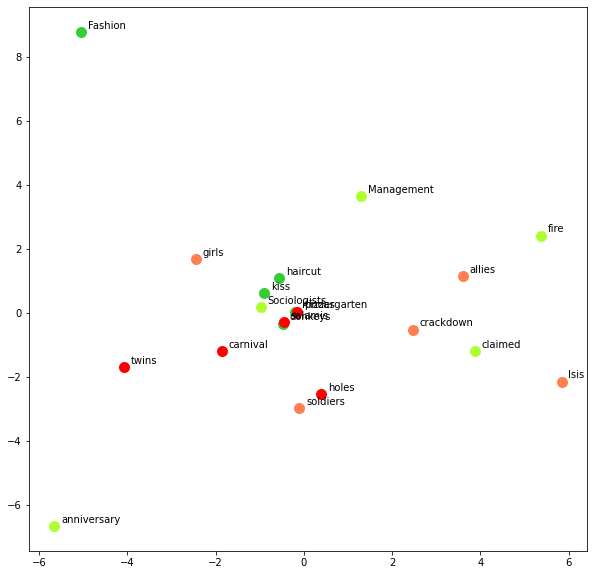

In [ ]:
# The words were chosen based on the following pattern:
# 5 original words from funny headlines
# 5 edited words from funny headlines
# 5 original words from boring headlines
# 5 edited words from boring headlines

stemmed_words= [
    'sociologist', 'claim', 'anniversari', 'fire', 'manag', 
    'donkey', 'haircut', 'kindergarten', 'kiss', 'fashion',
    'isi', 'girl', 'alli', 'soldier', 'crackdown',
    'twin', 'salami', 'hole', 'pizza', 'carniv']

labels = [
    'Sociologists', 'claimed', 'anniversary', 'fire', 'Management', 
    'donkeys', 'haircut', 'Kindergarten', 'kiss', 'Fashion',
    'Isis', 'girls', 'allies', 'soldiers', 'crackdown',
    'twins', 'salamis', 'holes', 'pizzas', 'carnival']

display_pca_scatterplot(word2vec_model_large, stemmed_words, labels)

In [ ]:
similarity_funny = []
similarity_boring = []

df_funny = medium_unk_train_df[medium_unk_train_df['meanGrade'] >= 2.2]
df_boring = medium_unk_train_df[(medium_unk_train_df['meanGrade'] <= 0.1) ]
skip = 0

for i in range(0, len(df_funny)):
    try:
        similarity_funny.append(word2vec_model_large.wv.similarity(df_funny.iloc[i]['edit'], df_funny.iloc[i]['original_word']))
        
    except: skip+=1

for i in range(0, len(df_boring)):
    try:
        similarity_boring.append(word2vec_model_large.wv.similarity(df_boring.iloc[i]['edit'], df_boring.iloc[i]['original_word']))
    except: skip+=1

#Mean similarity of original and edited word
print('Number of funny headlines evaluated:' , len(similarity_funny))
print('Number of boring headlines evaluated:' , len(similarity_boring))
print("Mean similarity original and edited word in funny headlines:", np.round(np.mean(similarity_funny),2))
print("Mean similarity original and edited word in boring headlines:", np.round(np.mean(similarity_boring),2))

#Is this a consistent measurement?
print("Standard deviation of similarity measure (funny headlines):", np.round(np.std(similarity_funny),2))
print("Standard deviation of similarity measure (boring headlines):", np.round(np.std(similarity_boring),2))
print(skip)


Number of funny headlines evaluated: 752
Number of boring headlines evaluated: 642
Mean similarity original and edited word in funny headlines: 0.06
Mean similarity original and edited word in boring headlines: 0.12
Standard deviation of similarity measure (funny headlines): 0.14
Standard deviation of similarity measure (boring headlines): 0.15
68


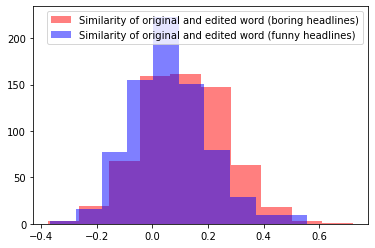

In [ ]:
plt.hist(similarity_boring,  label = 'Similarity of original and edited word (boring headlines)', color=(1,0,0,0.5))
plt.hist(similarity_funny,  label = 'Similarity of original and edited word (funny headlines)', color=(0,0,1,0.5))

plt.legend()


In [ ]:
# Testing the quality of similar word predictions - large model
girl_large = word2vec_model_large.wv.most_similar(positive=['girl'])
merkel_large = word2vec_model_large.wv.most_similar(positive=['merkel'])
uk_large = word2vec_model_large.wv.most_similar(positive=['uk'])

print("LARGE W2V MODEL:")
print(" ")
print("Most similar to GIRL:")
print([word[0] for word in girl_large])
print(" ")
print("Most similar to MERKEL:")
print([word[0] for word in merkel_large])
print(" ")
print("Most similar to UK:")
print([word[0] for word in uk_large])

print(" ")

# Testing the quality of similar word predictions - small model
girl = word2vec_model.wv.most_similar(positive=['girl'])
merkel = word2vec_model.wv.most_similar(positive=['merkel'])
uk = word2vec_model.wv.most_similar(positive=['uk'])

print(" ")
print(" ")
print("SMALL W2V MODEL:")
print(" ")
print("Most similar to GIRL:")
print([word[0] for word in girl])
print(" ")
print("Most similar to MERKEL:")
print([word[0] for word in merkel])
print(" ")
print("Most similar to UK:")
print([word[0] for word in uk])



LARGE W2V MODEL:
 
Most similar to GIRL:
['boy', 'daughter', 'son', 'kid', 'children', 'teen', 'toddler', 'feminist', 'mom', 'child']
 
Most similar to MERKEL:
['macron', 'ceasefir', 'maduro', 'erdogan', 'putin', 'turkey', 'leader', 'netanyahu', 'rouhani', 'vladimir']
 
Most similar to UK:
['germani', 'british', 'britain', 'australia', 'chines', 'eu', 'australian', 'german', 'worldwid', 'turkish']
 
 
 
SMALL W2V MODEL:
 
Most similar to GIRL:
['36', '14', 'landslid', 'pier', 'osha', 'autopilot', '250', 'greek', 'congo', 'eastern']
 
Most similar to MERKEL:
['unexpect', 'joint', 'bilater', 'playboy', 'villain', 'planner', 'leftist', 'migrant', 'alaska', 'botch']
 
Most similar to UK:
['bonu', 'miracl', 'crypto', 'dutch', 'austrian', 'toni', 'tens', 'exbritish', 'kimoon', 'depend']


#### Model Training (Scikit-learn)

In [ ]:
def get_embeddings(model, preprocessed_df, to_unk = False):
  '''
  Get the vector represetnations of the original and edit word in the processed corpus  from model
  Returns the difference between the represetnations and the corresponding mean grade for the headlines provided
  if to_unk - unseen words are assigned the representation for the "UNK" token
  else - unseen words are skipped
  '''
  w2v_repr_per_sentence = []
  label_per_sentence = []
  missed_count = 0 # check how many rows we are skipping due to oov
  unk_count = 0 # check how many unk replacements we make
  
  t = time.time()


  for index, row in preprocessed_df.iterrows():
    original, edit, label = row["original_word"], row["edit"], row["meanGrade"]
   
    # get representation for original word
    try:
      original_wv_test = model.wv[original.split()]
    except KeyError:
      if to_unk:
        # word not in training corpus - replace with UNK
        original_wv_test = model.wv["<UNK>"]
        unk_count+=1
      else:
        # word not in training corpus - SKIP
        missed_count+=1
        continue

    try:
      edit_wv_test = model.wv[edit.split()]
    except KeyError:
      if to_unk:
        # word not in training corpus - replace with UNK
        edit_wv_test = model.wv["<UNK>"]
        unk_count +=1
      else:
        # word not in training corpus - SKIP
        missed_count+=1
        continue

    # if words replaced are several words e.g. north korea, average the representation
    if original_wv_test.shape[0] >1:
      original_wv_test = np.expand_dims(np.average(original_wv_test, axis=0), axis=0)
    
    if edit_wv_test.shape[0] > 1:
      edit_wv_test = np.expand_dims(np.average(edit_wv_test, axis=0), axis=0)

    # take the difference in representation between the original and edited word
    diff = np.squeeze(original_wv_test - edit_wv_test, axis=0)

    w2v_repr_per_sentence.append(diff)
    label_per_sentence.append(label)
  
  print('Time to collect the word embeddings: {} seconds'.format(round((time.time() - t), 2)))

  assert len(w2v_repr_per_sentence) == len(label_per_sentence), "Diff number of x and y for model"

  if to_unk:
    print(f"Original corpus length: {len(preprocessed_df)}, Number of headlines replaced with UNK: {unk_count}")
  else:
    print(f"Original corpus length: {len(preprocessed_df)}, Number of headlines skipped (out of vocab): {missed_count}")

  return w2v_repr_per_sentence, label_per_sentence
    
      



##### Original Training Corpus: NO UNKs

In [ ]:
# Prepare Data for gridsearch 

# training data: Only original corpus, using W2V trained only on original corpus

# Get preprocessed headlines using original corpus
preprocessed_train_df = preprocess_dataframe(train_df.copy(), start_end_tok = False, merge_headlines = True, original_word = True)
display(preprocessed_train_df.head(), display_id=True)

# create tokenised corpus
vocab, original_tokenised_corpus = create_vocab(preprocessed_train_df['edited_headline'])

print("Original corpus:", Counter(item for sublist in original_tokenised_corpus for item in sublist))
print(len(vocab))

# train word2vec model on original corpus with rare words removed
word2vec_model_original = Word2Vec(window = 2, size=100)

t = time.time()

word2vec_model_original.build_vocab(original_tokenised_corpus, progress_per=10000, min_count=1)
word2vec_model_original.train(original_tokenised_corpus, total_examples=word2vec_model_original.corpus_count, epochs=30, report_delay=1)

print('Time to train the word embeddings: {} seconds'.format(round((time.time() - t), 2)))

# Get the wv representation and the corresponding mean grade for training regressor
print('Collecting original and edited word vectors')
w2v_repr_per_sentence, label_per_sentence = get_embeddings(word2vec_model_original, preprocessed_train_df, to_unk=False)



Step 1 (Lowercase): france is ‘ hunting down its citizens who joined twins ’ without trial in iraq
Step 2 (Punctuation removal):  france is  hunting down its citizens who joined twins  without trial in iraq
Step 3 (Stopword removal): france hunting citizens joined twins without trial iraq
Step 4 (Stemming): franc hunt citizen join twin without trial iraq
Step 6 (Merge): franc hunt citizen join isi without trial iraq franc hunt citizen join twin without trial iraq


id  ...                                    edited_headline
0  14530  ...  franc hunt citizen join isi without trial iraq...
1  13034  ...  pentagon claim 2000 increas russian troll syri...
2   8731  ...  iceland pm call snap vote pedophil furor crash...
3     76  ...  appar first iran israel engag militarili appar...
4   6164  ...  trump told week ago flynn misl vice presid tru...

[5 rows x 8 columns]

Original corpus: Counter({'trump': 7044, 'say': 1657, 'us': 1521, 'hous': 1061, 'donald': 764, 'new': 738, 'nt': 734, 'white': 722, 'russia': 688, 'presid': 613, 'gop': 594, 'korea': 585, 'report': 559, 'democrat': 556, 'senat': 556, 'republican': 553, 'north': 541, 'russian': 506, 'bill': 505, 'call': 476, 'state': 428, 'tax': 423, 'plan': 406, 'back': 395, 'attack': 390, 'news': 383, 'could': 378, 'want': 375, 'mueller': 368, 'get': 358, 'ban': 349, 'china': 344, 'fire': 338, 'investig': 328, 'may': 324, 'obama': 324, 'elect': 323, 'meet': 306, 'offici': 302, 'time': 290, 'polit': 286, 'deal': 285, 'obamacar': 284, 'kill': 281, 'vote': 280, 'clinton': 278, 'american': 274, 'first': 270, 'face': 270, 'health': 258, 'govern': 258, 'ask': 256, 'would': 254, 'fbi': 253, 'rule': 253, 'protest': 253, 'take': 244, 'syria': 239, 'militari': 239, 'make': 237, 'day': 235, 'cut': 234, 'war': 233, 'one': 231, 'former': 230, 'comey': 230, 'warn': 229, 'campaign': 226, 'show': 225, 'support': 225,

In [ ]:
# Grid search on original corpus
'''
Chosen models: SGDRegressor, SVR, ExtraTreesRegressor

SGD regressor - linear model with stochastic gradient descent. 
  Key parameters to experiement with: learning rate, regularisation
ExtraTreesRegressor - 'extreme random forests' for the extra trees for each feature, a random split value is chosen - this increases more diversified trees + speeds up calculation. 
  Key parameter to explore: number of trees
SVR - support vector regression
  Key parameters to experiment with: kernel type

'''

parameters = [ {
                  "model":[SGDRegressor()],
                  "name": "SGDRegressor",
                  "model__penalty": ["l1", "l2"],
                  "model__learning_rate": ["constant", "adaptive"],
              },

              {
                  "model":[SVR()],
                  "name":"SVR",
                
                  "model__kernel": ["linear", "rbf", "poly"]
              }, 

              {
                  "model":[ExtraTreesRegressor()],
                  "name": "ExtraTreesRegressor",
                  "model__n_estimators": [10, 30, 50, 80, 100]
              }

             
              ]

# get k folds for cross validation
n_splits = 2
train_val_split = 0.2
Splitter = ShuffleSplit(n_splits, test_size=train_val_split)
train_and_val_indices = Splitter.split(np.zeros_like(label_per_sentence), label_per_sentence) # iterator containing indices for (train, val) with 2 items

# run grid search
results = []
for params in parameters:
  model = params["model"][0]

  params.pop("model") # now we are left with the grid search params for this model in params
  name = params.pop("name") # for printing
  pipeline = Pipeline([("model", model)]) 

  # grid search
  grid = GridSearchCV(pipeline, param_grid=params,scoring=["neg_mean_squared_error", "neg_root_mean_squared_error"], cv=Splitter, verbose=3, refit="neg_root_mean_squared_error", return_train_score=True)
  
  t = time.time()
  
  grid.fit(w2v_repr_per_sentence, label_per_sentence)
  
  print('Time to to run hyperparam search on {}: {} seconds'.format(name, round((time.time() - t), 2)))
  print(f"Best {name}: {grid.best_score_}, Best params: {grid.best_params_}")
  
  results.append({"grid": grid, "name":name, "cv results": grid.cv_results_, "best estimator": grid.best_estimator_, "best score": grid.best_score_, "best_params": grid.best_params_})



  

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] model__learning_rate=constant, model__penalty=l1 ................
[CV]  model__learning_rate=constant, model__penalty=l1, neg_mean_squared_error=(train=-0.375, test=-0.371), neg_root_mean_squared_error=(train=-0.613, test=-0.609), total=   0.2s
[CV] model__learning_rate=constant, model__penalty=l1 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  model__learning_rate=constant, model__penalty=l1, neg_mean_squared_error=(train=-0.382, test=-0.392), neg_root_mean_squared_error=(train=-0.618, test=-0.626), total=   0.2s
[CV] model__learning_rate=constant, model__penalty=l2 ................
[CV]  model__learning_rate=constant, model__penalty=l2, neg_mean_squared_error=(train=-0.835, test=-0.815), neg_root_mean_squared_error=(train=-0.914, test=-0.903), total=   0.1s
[CV] model__learning_rate=constant, model__penalty=l2 ................
[CV]  model__learning_rate=constant, model__penalty=l2, neg_mean_squared_error=(train=-0.815, test=-0.906), neg_root_mean_squared_error=(train=-0.903, test=-0.952), total=   0.1s
[CV] model__learning_rate=adaptive, model__penalty=l1 ................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV]  model__learning_rate=adaptive, model__penalty=l1, neg_mean_squared_error=(train=-0.332, test=-0.336), neg_root_mean_squared_error=(train=-0.576, test=-0.579), total=   0.5s
[CV] model__learning_rate=adaptive, model__penalty=l1 ................
[CV]  model__learning_rate=adaptive, model__penalty=l1, neg_mean_squared_error=(train=-0.330, test=-0.342), neg_root_mean_squared_error=(train=-0.575, test=-0.584), total=   0.5s
[CV] model__learning_rate=adaptive, model__penalty=l2 ................
[CV]  model__learning_rate=adaptive, model__penalty=l2, neg_mean_squared_error=(train=-0.331, test=-0.336), neg_root_mean_squared_error=(train=-0.576, test=-0.579), total=   0.2s
[CV] model__learning_rate=adaptive, model__penalty=l2 ................
[CV]  model__learning_rate=adaptive, model__penalty=l2, neg_mean_squared_error=(train=-0.330, test=-0.342), neg_root_mean_squared_error=(train=-0.575, test=-0.584), total=   0.2s


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.9s finished


Time to to run hyperparam search on SGDRegressor: 2.48 seconds
Best SGDRegressor: -0.581870825171391, Best params: {'model__learning_rate': 'adaptive', 'model__penalty': 'l1'}
Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] model__kernel=linear ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model__kernel=linear, neg_mean_squared_error=(train=-0.332, test=-0.351), neg_root_mean_squared_error=(train=-0.577, test=-0.593), total= 1.1min
[CV] model__kernel=linear ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV]  model__kernel=linear, neg_mean_squared_error=(train=-0.333, test=-0.357), neg_root_mean_squared_error=(train=-0.577, test=-0.598), total= 1.1min
[CV] model__kernel=rbf ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min remaining:    0.0s


[CV]  model__kernel=rbf, neg_mean_squared_error=(train=-0.239, test=-0.356), neg_root_mean_squared_error=(train=-0.489, test=-0.597), total=  11.8s
[CV] model__kernel=rbf ...............................................
[CV]  model__kernel=rbf, neg_mean_squared_error=(train=-0.241, test=-0.354), neg_root_mean_squared_error=(train=-0.491, test=-0.595), total=  11.8s
[CV] model__kernel=poly ..............................................
[CV]  model__kernel=poly, neg_mean_squared_error=(train=-0.227, test=-0.409), neg_root_mean_squared_error=(train=-0.477, test=-0.639), total=  11.7s
[CV] model__kernel=poly ..............................................
[CV]  model__kernel=poly, neg_mean_squared_error=(train=-0.230, test=-0.409), neg_root_mean_squared_error=(train=-0.479, test=-0.639), total=  12.2s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  3.6min finished


Time to to run hyperparam search on SVR: 314.7 seconds
Best SVR: -0.5952799569353339, Best params: {'model__kernel': 'linear'}
Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] model__n_estimators=10 ..........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model__n_estimators=10, neg_mean_squared_error=(train=-0.007, test=-0.386), neg_root_mean_squared_error=(train=-0.086, test=-0.621), total=   1.5s
[CV] model__n_estimators=10 ..........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV]  model__n_estimators=10, neg_mean_squared_error=(train=-0.007, test=-0.381), neg_root_mean_squared_error=(train=-0.085, test=-0.617), total=   1.4s
[CV] model__n_estimators=30 ..........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s


[CV]  model__n_estimators=30, neg_mean_squared_error=(train=-0.007, test=-0.356), neg_root_mean_squared_error=(train=-0.086, test=-0.597), total=   4.4s
[CV] model__n_estimators=30 ..........................................
[CV]  model__n_estimators=30, neg_mean_squared_error=(train=-0.007, test=-0.359), neg_root_mean_squared_error=(train=-0.085, test=-0.599), total=   4.4s
[CV] model__n_estimators=50 ..........................................
[CV]  model__n_estimators=50, neg_mean_squared_error=(train=-0.007, test=-0.356), neg_root_mean_squared_error=(train=-0.086, test=-0.597), total=   7.5s
[CV] model__n_estimators=50 ..........................................
[CV]  model__n_estimators=50, neg_mean_squared_error=(train=-0.007, test=-0.358), neg_root_mean_squared_error=(train=-0.085, test=-0.599), total=   7.4s
[CV] model__n_estimators=80 ..........................................
[CV]  model__n_estimators=80, neg_mean_squared_error=(train=-0.007, test=-0.354), neg_root_mean_squared_

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.3min finished


Time to to run hyperparam search on ExtraTreesRegressor: 95.86 seconds
Best ExtraTreesRegressor: -0.5956426919861986, Best params: {'model__n_estimators': 80}


In [ ]:
# Display GridSearch Results for Original Data on Validation Set

saved_models = dict()
for i in range(len(results)):
  print(f"\n\n\nGrid Search Results for {results[i]['name']}")
  df = pd.DataFrame(results[i]["cv results"])[['mean_train_neg_root_mean_squared_error','mean_test_neg_root_mean_squared_error', 'rank_test_neg_root_mean_squared_error', "params"]].round(4)
  df[['mean_train_neg_root_mean_squared_error','mean_test_neg_root_mean_squared_error']] = df[['mean_train_neg_root_mean_squared_error','mean_test_neg_root_mean_squared_error']].apply(lambda x:-x)
  display(df)
  print(f"Best parameters: {results[i]['best_params']}, Best MSE: {results[i]['best score']*-1}")
  # print(pd.DataFrame(results[i]["cv results"])[['params']])
  saved_models[results[i]["name"]] = results[i]["best estimator"]

best_estimator_MLP = results[1]["best estimator"]





Grid Search Results for SGDRegressor


mean_train_neg_root_mean_squared_error  ...                                             params
0                                  0.6154  ...  {'model__learning_rate': 'constant', 'model__p...
1                                  0.9082  ...  {'model__learning_rate': 'constant', 'model__p...
2                                  0.5753  ...  {'model__learning_rate': 'adaptive', 'model__p...
3                                  0.5752  ...  {'model__learning_rate': 'adaptive', 'model__p...

[4 rows x 4 columns]

Best parameters: {'model__learning_rate': 'adaptive', 'model__penalty': 'l1'}, Best MSE: 0.581870825171391



Grid Search Results for SVR


mean_train_neg_root_mean_squared_error  ...                       params
0                                  0.5770  ...  {'model__kernel': 'linear'}
1                                  0.4900  ...     {'model__kernel': 'rbf'}
2                                  0.4778  ...    {'model__kernel': 'poly'}

[3 rows x 4 columns]

Best parameters: {'model__kernel': 'linear'}, Best MSE: 0.5952799569353339



Grid Search Results for ExtraTreesRegressor


mean_train_neg_root_mean_squared_error  ...                        params
0                                  0.0857  ...   {'model__n_estimators': 10}
1                                  0.0857  ...   {'model__n_estimators': 30}
2                                  0.0857  ...   {'model__n_estimators': 50}
3                                  0.0857  ...   {'model__n_estimators': 80}
4                                  0.0857  ...  {'model__n_estimators': 100}

[5 rows x 4 columns]

Best parameters: {'model__n_estimators': 80}, Best MSE: 0.5956426919861986


Evaluate best model from GridSearch on Dev set

In [ ]:
# GET MSE ON LABELLED, UNSEEN, DEV SET USING BEST MODEL
# SKIP UNSEEN WORDS

print("Processing Development Set")
preprocessed_dev_df = preprocess_dataframe(dev_df_w_labels.copy(), stopwords_removal=True, stemming=True, start_end_tok=False, original_word=True)
print("Length of dev set", len(preprocessed_dev_df))
# Get the wv representation using W2V original and the corresponding mean grade for test data
print('Collecting original and edited word vectors')
w2v_repr_per_sentence_test, label_per_sentence_test = get_embeddings(word2vec_model_original, preprocessed_dev_df, to_unk=False)


# Train best models w. params from grid search on full train set
print("Training the best models on the original train set")
models = dict()
best_sgd = SGDRegressor(penalty="l1", learning_rate="adaptive", verbose=3).fit(w2v_repr_per_sentence, label_per_sentence)
best_svr = SVR(kernel="linear", verbose=3).fit(w2v_repr_per_sentence, label_per_sentence)
best_trees = ExtraTreesRegressor(n_estimators=100, verbose=3).fit(w2v_repr_per_sentence, label_per_sentence)


# for saving down
models["best_estimator"] = [("SGD", best_sgd), ("SVR", best_svr), ("ExtraTrees",best_trees)]
models["name"] = []
models["dev RMSE"] = []
models["dev MSE"] = []
models["train MSE"] = []
models["train RMSE"] = []

prediction_list = []
train_prediction_list = []

# Get SSE / MSE using UNKS
for name, best_estimator in models["best_estimator"]:
  # without unk
  predictions = best_estimator.predict(w2v_repr_per_sentence_test)
  prediction_list.append(predictions)
  sse, mse = model_performance(predictions, label_per_sentence_test, True)
  models["name"].append(name)
  models["dev RMSE"].append(np.sqrt(mse))
  models["dev MSE"].append(mse)

models.pop("best_estimator")
results = pd.DataFrame(models)

display(results)



Processing Development Set
Step 1 (Lowercase): thousands of gay and bisexual swans convicted of long-abolished sexual offences are posthumously pardoned
Step 2 (Punctuation removal):  thousands of gay and bisexual swans convicted of longabolished sexual offences are posthumously pardoned
Step 3 (Stopword removal): thousands gay bisexual swans convicted longabolished sexual offences posthumously pardoned
Step 4 (Stemming): thousand gay bisexu swan convict longabolish sexual offenc posthum pardon
Length of dev set 2419
Time to collect the word embeddings: 0.25 seconds
Original corpus length: 2419, Number of headlines skipped (out of vocab): 369
Training the best models on the original train set
-- Epoch 1
Norm: 2.15, NNZs: 93, Bias: 0.806574, T: 9610, Avg. loss: 0.382658
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 3.94, NNZs: 71, Bias: 0.919263, T: 19220, Avg. loss: 0.324253
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 5.37, NNZs: 67, Bias: 0.846208, T: 28830, Avg. loss: 0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   18.5s finished


| MSE: 0.33 | RMSE: 0.58 |
| MSE: 0.34 | RMSE: 0.58 |
| MSE: 0.34 | RMSE: 0.58 |


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


name  dev RMSE   dev MSE
0         SGD  0.576425  0.332266
1         SVR  0.584045  0.341109
2  ExtraTrees  0.584910  0.342119

name  dev RMSE with UNK  ...  dev RMSE w/o UNK  dev MSE w/o UNK
0         SGD           0.592191  ...          0.590030         0.348135
1         MLP           0.619193  ...          0.618561         0.382618
2  ExtraTrees           0.607219  ...          0.606158         0.367427

[3 rows x 5 columns]


DEV performance:


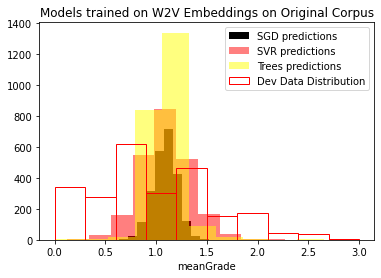

In [ ]:
display(results)
print("\nDEV performance:")
plt.figure()
plt.hist(prediction_list[0],  label = 'SGD predictions', color=(0,0,0,1))
plt.hist(prediction_list[1],  label = 'SVR predictions', color=(1,0,0,0.5))
plt.hist(prediction_list[2],  label = 'Trees predictions', color=(1,1,0,0.5))
plt.hist(preprocessed_dev_df["meanGrade"], label="Dev Data Distribution", color=(1,1,1, 0), edgecolor="r")
plt.legend()
plt.xlabel("meanGrade")
plt.title("Models trained on W2V Embeddings on Original Corpus")
plt.savefig("original_dataset_dev_results.jpg")

##### Augmented Training Corpus: With UNKs


In [ ]:
# train word to vec with the larger corpus (funlines + news headlines)

# Get preprocessed headlines
print("Processing original data")
preprocessed_train_df = preprocess_dataframe(train_df, start_end_tok = False, merge_headlines = True, original_word = True)
print("Processing funlines data")
# Get additional preprocessed funlines
preprocessed_funlines = preprocess_dataframe(funlines_df, start_end_tok = False, merge_headlines = True, original_word = True)

# Build a large W2V training corpus
medium_preprocessed_train_df = pd.concat([preprocessed_train_df, preprocessed_funlines])
print("Adding additional headlines data")
large_preprocessed_train_df = enrich_headline_data(medium_preprocessed_train_df['edited_headline'], headlines_df, verbose = True)


# get tokenised corpus
large_vocab, large_tokenised_corpus = create_vocab(large_preprocessed_train_df)

# Replace rare words in corpus with UNK tokens
# medium unk train df is the labelled + preprocessed funlines + original dataset for training
print("Replacing rare words with UNK token...")
large_tokenised_corpus, medium_unk_train_df =  rare_words_removal(tokenised_corpus=large_tokenised_corpus, unk_threshold = 1, dataframe = medium_preprocessed_train_df, replace_in_dataframe = True)
print("Number of UNK tokens:", Counter([item for sublist in large_tokenised_corpus for item in sublist])["<UNK>"])
display(medium_unk_train_df.head())

Processing original data
Step 1 (Lowercase): france is ‘ hunting down its citizens who joined twins ’ without trial in iraq
Step 2 (Punctuation removal):  france is  hunting down its citizens who joined twins  without trial in iraq
Step 3 (Stopword removal): france hunting citizens joined twins without trial iraq
Step 4 (Stemming): franc hunt citizen join twin without trial iraq
Step 6 (Merge): franc hunt citizen join isi without trial iraq franc hunt citizen join twin without trial iraq
Processing funlines data
Step 1 (Lowercase): donald trump misunderstands g7 talks on climate crisis and amazon fires
Step 2 (Punctuation removal):  donald trump misunderstands g7 talks on climate crisis and amazon fires
Step 3 (Stopword removal): donald trump misunderstands g7 talks climate crisis amazon fires
Step 4 (Stemming): donald trump misunderstand g7 talk climat crisi amazon fire
Step 6 (Merge): donald trump skip g7 talk climat crisi amazon fire donald trump misunderstand g7 talk climat crisi a

id  ...                                    edited_headline
0  14530  ...  franc hunt citizen join isi without trial iraq...
1  13034  ...  pentagon claim 2000 increas russian troll syri...
2   8731  ...  iceland pm call snap vote pedophil furor crash...
3     76  ...  appar first iran israel engag militarili appar...
4   6164  ...  trump told week ago flynn misl vice presid tru...

[5 rows x 7 columns]

In [ ]:

# Train W2V based on full available data
t = time.time()
word2vec_model_large = Word2Vec(window = 2, size=100) # Note tried window size = 5, but lead to slightly poorer results

word2vec_model_large.build_vocab(large_tokenised_corpus, progress_per=10000, min_count=1)
word2vec_model_large.train(large_tokenised_corpus, total_examples=word2vec_model_large.corpus_count, epochs=30, report_delay=1)

print('Time to train the word embeddings: {} seconds'.format(round((time.time() - t), 2)))


Time to train the word embeddings: 115.95 seconds


In [ ]:
# Prepare Data for gridsearch 

# NOTE OOV words here are ones where original / edited word was a stop word that was removed in preprocessing therefore we just skipped it
# training data: original + funlines data
w2v_repr_per_sentence, label_per_sentence = get_embeddings(word2vec_model_large, medium_unk_train_df, to_unk=True)


Time to collect the word embeddings: 1.83 seconds
Original corpus length: 17900, Number of headlines replaced with UNK: 52


In [ ]:
# Grid search
'''
Chosen models: SGDRegressor, SVR, ExtraTreesRegressor

SGD regressor - linear model with stochastic gradient descent. 
  Key parameters to experiement with: learning rate, regularisation
ExtraTreesRegressor - 'extreme random forests' for the extra trees for each feature, a random split value is chosen - this increases more diversified trees + speeds up calculation. 
  Key parameter to explore: number of trees
SVR - Cannot use here as it is VERY SLOW for a larger dataset - more than quadratic complexity

'''

parameters = [ {
                  "model":[SGDRegressor()],
                  "name": "SGDRegressor",
                  "model__penalty": ["l1", "l2"],
                  "model__learning_rate": ["constant", "adaptive"],
              },

              {
                  "model":[MLPRegressor()],
                  "name":"MLP",
                  "model__hidden_layer_sizes":[(100,), (100,100)],
                  "model__activation":["relu"],
                  "model__learning_rate":["adaptive"],
                  "model__alpha": [0.01, 0.001],
                  "model__early_stopping":[True]

              }, 

              {
                  "model":[ExtraTreesRegressor()],
                  "name": "ExtraTreesRegressor",
                  "model__n_estimators": [10, 30, 50, 80, 100]
              }

             
              ]

# get k folds for cross validation
n_splits = 2
train_val_split = 0.2
Splitter = ShuffleSplit(n_splits, test_size=train_val_split)
train_and_val_indices = Splitter.split(np.zeros_like(label_per_sentence), label_per_sentence) # iterator containing indices for (train, val) with 2 items

results = []
for params in parameters:
  model = params["model"][0]

  params.pop("model") # now we are left with the grid search params for this model in params
  name = params.pop("name") # for printing
  pipeline = Pipeline([("model", model)]) 

  # grid search
  grid = GridSearchCV(pipeline, param_grid=params,scoring=["neg_mean_squared_error", "neg_root_mean_squared_error"], cv=Splitter, verbose=3, refit="neg_root_mean_squared_error", return_train_score=True)
  
  t = time.time()
  
  grid.fit(w2v_repr_per_sentence, label_per_sentence)
  
  
  print('Time to to run hyperparam search on {}: {} seconds'.format(name, round((time.time() - t), 2)))
  print(f"Best {name}: {grid.best_score_}, Best params: {grid.best_params_}")
  
  
  results.append({"grid": grid, "name":name, "cv results": grid.cv_results_, "best estimator": grid.best_estimator_, "best score": grid.best_score_, "best_params": grid.best_params_})



  

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] model__learning_rate=constant, model__penalty=l1 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model__learning_rate=constant, model__penalty=l1, neg_mean_squared_error=(train=-0.443, test=-0.453), neg_root_mean_squared_error=(train=-0.666, test=-0.673), total=   0.5s
[CV] model__learning_rate=constant, model__penalty=l1 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  model__learning_rate=constant, model__penalty=l1, neg_mean_squared_error=(train=-0.416, test=-0.424), neg_root_mean_squared_error=(train=-0.645, test=-0.651), total=   0.6s
[CV] model__learning_rate=constant, model__penalty=l2 ................
[CV]  model__learning_rate=constant, model__penalty=l2, neg_mean_squared_error=(train=-2.119, test=-2.150), neg_root_mean_squared_error=(train=-1.456, test=-1.466), total=   0.1s
[CV] model__learning_rate=constant, model__penalty=l2 ................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  model__learning_rate=constant, model__penalty=l2, neg_mean_squared_error=(train=-2.514, test=-2.595), neg_root_mean_squared_error=(train=-1.586, test=-1.611), total=   0.1s
[CV] model__learning_rate=adaptive, model__penalty=l1 ................
[CV]  model__learning_rate=adaptive, model__penalty=l1, neg_mean_squared_error=(train=-0.340, test=-0.350), neg_root_mean_squared_error=(train=-0.583, test=-0.591), total=   1.0s
[CV] model__learning_rate=adaptive, model__penalty=l1 ................
[CV]  model__learning_rate=adaptive, model__penalty=l1, neg_mean_squared_error=(train=-0.340, test=-0.350), neg_root_mean_squared_error=(train=-0.583, test=-0.592), total=   0.9s
[CV] model__learning_rate=adaptive, model__penalty=l2 ................
[CV]  model__learning_rate=adaptive, model__penalty=l2, neg_mean_squared_error=(train=-0.340, test=-0.350), neg_root_mean_squared_error=(train=-0.583, test=-0.591), total=   0.3s
[CV] model__learning_rate=adaptive, model__penalty=l2 ................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.1s finished


Time to to run hyperparam search on SGDRegressor: 4.42 seconds
Best SGDRegressor: -0.5913550291650029, Best params: {'model__learning_rate': 'adaptive', 'model__penalty': 'l2'}
Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] model__activation=relu, model__alpha=0.01, model__early_stopping=True, model__hidden_layer_sizes=(100,), model__learning_rate=adaptive 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model__activation=relu, model__alpha=0.01, model__early_stopping=True, model__hidden_layer_sizes=(100,), model__learning_rate=adaptive, neg_mean_squared_error=(train=-0.278, test=-0.397), neg_root_mean_squared_error=(train=-0.528, test=-0.630), total=   2.4s
[CV] model__activation=relu, model__alpha=0.01, model__early_stopping=True, model__hidden_layer_sizes=(100,), model__learning_rate=adaptive 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV]  model__activation=relu, model__alpha=0.01, model__early_stopping=True, model__hidden_layer_sizes=(100,), model__learning_rate=adaptive, neg_mean_squared_error=(train=-0.271, test=-0.406), neg_root_mean_squared_error=(train=-0.520, test=-0.638), total=   2.5s
[CV] model__activation=relu, model__alpha=0.01, model__early_stopping=True, model__hidden_layer_sizes=(100, 100), model__learning_rate=adaptive 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s


[CV]  model__activation=relu, model__alpha=0.01, model__early_stopping=True, model__hidden_layer_sizes=(100, 100), model__learning_rate=adaptive, neg_mean_squared_error=(train=-0.311, test=-0.379), neg_root_mean_squared_error=(train=-0.557, test=-0.615), total=   2.5s
[CV] model__activation=relu, model__alpha=0.01, model__early_stopping=True, model__hidden_layer_sizes=(100, 100), model__learning_rate=adaptive 
[CV]  model__activation=relu, model__alpha=0.01, model__early_stopping=True, model__hidden_layer_sizes=(100, 100), model__learning_rate=adaptive, neg_mean_squared_error=(train=-0.278, test=-0.404), neg_root_mean_squared_error=(train=-0.527, test=-0.636), total=   3.3s
[CV] model__activation=relu, model__alpha=0.001, model__early_stopping=True, model__hidden_layer_sizes=(100,), model__learning_rate=adaptive 
[CV]  model__activation=relu, model__alpha=0.001, model__early_stopping=True, model__hidden_layer_sizes=(100,), model__learning_rate=adaptive, neg_mean_squared_error=(train=-0

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   21.0s finished


Time to to run hyperparam search on MLP: 24.53 seconds
Best MLP: -0.6198819870433614, Best params: {'model__activation': 'relu', 'model__alpha': 0.001, 'model__early_stopping': True, 'model__hidden_layer_sizes': (100, 100), 'model__learning_rate': 'adaptive'}
Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] model__n_estimators=10 ..........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model__n_estimators=10, neg_mean_squared_error=(train=-0.008, test=-0.401), neg_root_mean_squared_error=(train=-0.089, test=-0.633), total=   2.7s
[CV] model__n_estimators=10 ..........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV]  model__n_estimators=10, neg_mean_squared_error=(train=-0.008, test=-0.403), neg_root_mean_squared_error=(train=-0.089, test=-0.635), total=   2.7s
[CV] model__n_estimators=30 ..........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.5s remaining:    0.0s


[CV]  model__n_estimators=30, neg_mean_squared_error=(train=-0.008, test=-0.377), neg_root_mean_squared_error=(train=-0.089, test=-0.614), total=   8.1s
[CV] model__n_estimators=30 ..........................................
[CV]  model__n_estimators=30, neg_mean_squared_error=(train=-0.008, test=-0.379), neg_root_mean_squared_error=(train=-0.089, test=-0.616), total=   8.2s
[CV] model__n_estimators=50 ..........................................
[CV]  model__n_estimators=50, neg_mean_squared_error=(train=-0.008, test=-0.372), neg_root_mean_squared_error=(train=-0.089, test=-0.610), total=  13.5s
[CV] model__n_estimators=50 ..........................................
[CV]  model__n_estimators=50, neg_mean_squared_error=(train=-0.008, test=-0.375), neg_root_mean_squared_error=(train=-0.089, test=-0.612), total=  13.4s
[CV] model__n_estimators=80 ..........................................
[CV]  model__n_estimators=80, neg_mean_squared_error=(train=-0.008, test=-0.367), neg_root_mean_squared_

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.4min finished


Time to to run hyperparam search on ExtraTreesRegressor: 179.17 seconds
Best ExtraTreesRegressor: -0.6068926205323599, Best params: {'model__n_estimators': 100}





Grid Search Results for SGDRegressor


mean_train_neg_root_mean_squared_error  ...                                             params
0                                  0.6553  ...  {'model__learning_rate': 'constant', 'model__p...
1                                  1.5207  ...  {'model__learning_rate': 'constant', 'model__p...
2                                  0.5833  ...  {'model__learning_rate': 'adaptive', 'model__p...
3                                  0.5833  ...  {'model__learning_rate': 'adaptive', 'model__p...

[4 rows x 4 columns]

Best parameters: {'model__learning_rate': 'adaptive', 'model__penalty': 'l2'}, Best MSE: 0.5913550291650029



Grid Search Results for MLP


mean_train_neg_root_mean_squared_error  ...                                             params
0                                  0.5240  ...  {'model__activation': 'relu', 'model__alpha': ...
1                                  0.5424  ...  {'model__activation': 'relu', 'model__alpha': ...
2                                  0.5373  ...  {'model__activation': 'relu', 'model__alpha': ...
3                                  0.5148  ...  {'model__activation': 'relu', 'model__alpha': ...

[4 rows x 4 columns]

Best parameters: {'model__activation': 'relu', 'model__alpha': 0.001, 'model__early_stopping': True, 'model__hidden_layer_sizes': (100, 100), 'model__learning_rate': 'adaptive'}, Best MSE: 0.6198819870433614



Grid Search Results for ExtraTreesRegressor


mean_train_neg_root_mean_squared_error  ...                        params
0                                  0.0893  ...   {'model__n_estimators': 10}
1                                  0.0893  ...   {'model__n_estimators': 30}
2                                  0.0893  ...   {'model__n_estimators': 50}
3                                  0.0893  ...   {'model__n_estimators': 80}
4                                  0.0893  ...  {'model__n_estimators': 100}

[5 rows x 4 columns]

Best parameters: {'model__n_estimators': 100}, Best MSE: 0.6068926205323599


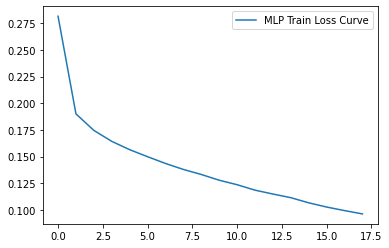

In [ ]:
# Display GridSearch Results for Full Available Data
saved_models = dict()
for i in range(len(results)):
  print(f"\n\n\nGrid Search Results for {results[i]['name']}")
  df = pd.DataFrame(results[i]["cv results"])[['mean_train_neg_root_mean_squared_error','mean_test_neg_root_mean_squared_error', 'rank_test_neg_root_mean_squared_error', "params"]].round(4)
  df[['mean_train_neg_root_mean_squared_error','mean_test_neg_root_mean_squared_error']] = df[['mean_train_neg_root_mean_squared_error','mean_test_neg_root_mean_squared_error']].apply(lambda x:-x)
  display(df)
  print(f"Best parameters: {results[i]['best_params']}, Best MSE: {results[i]['best score']*-1}")
  saved_models[results[i]["name"]] = results[i]["best estimator"]

best_estimator_MLP = results[1]["best estimator"]

losses = best_estimator_MLP["model"].loss_curve_
iter = np.arange(0,len(losses),1)
plt.plot(iter, losses, label= "MLP Train Loss Curve")
plt.legend()
plt.show()




In [ ]:
# GET MSE ON LABELLED, UNSEEN, DEV SET USING BEST MODELS FROM GRID SEARCH


preprocessed_dev_df = preprocess_dataframe(dev_df_w_labels.copy(), stopwords_removal=True, stemming=True, start_end_tok=False, original_word=True)
print(f"There are {len(preprocessed_dev_df)} headlines in the dev set")

# Get the wv representation using W2V original and the corresponding mean grade for test data

# 1) REPLACE UNSEEN WORDS WITH UNK

print('Collecting original and edited word vectors, with UNK')
w2v_repr_per_sentence_test, label_per_sentence_test = get_embeddings(word2vec_model_large, preprocessed_dev_df, to_unk=True)

# 2) SKIP HEADLINES WITH UNSEEN ROWS (NO UNKS)

print('Collecting original and edited word vectors, without UNK')
w2v_repr_per_sentence_test_skip , label_per_sentence_test_skip = get_embeddings(word2vec_model_large, preprocessed_dev_df, to_unk=False)

# Train best models on full train set
models = dict()
best_sgd = SGDRegressor(penalty="l1", learning_rate="adaptive", verbose=3).fit(w2v_repr_per_sentence, label_per_sentence)
best_MLP = MLPRegressor(alpha=0.01, early_stopping=True, hidden_layer_sizes=(100,100), learning_rate="adaptive", activation="relu").fit(w2v_repr_per_sentence, label_per_sentence)
best_trees = ExtraTreesRegressor(n_estimators=80).fit(w2v_repr_per_sentence, label_per_sentence)

# for saving down
models["best_estimator"] = [("SGD", best_sgd), ("MLP", best_MLP), ("ExtraTrees",best_trees)]
models["name"] = []
models["dev RMSE with UNK"] = []
models["dev MSE with UNK"] = []
models["dev RMSE w/o UNK"] = []
models["dev MSE w/o UNK"] = []

prediction_list = []
prediction_list_unk = []

# Get SSE / MSE using UNKS
for name, best_estimator in models["best_estimator"]:
  # without unk
  predictions = best_estimator.predict(w2v_repr_per_sentence_test_skip)
  prediction_list.append(predictions)
  print("Model without UNK:", name)
  sse, mse = model_performance(predictions, label_per_sentence_test_skip, True)
  
  models["dev RMSE w/o UNK"].append(np.sqrt(mse))
  models["dev MSE w/o UNK"].append(mse)
  print("Model with UNK:", name)
  # with unk
  predictions_2 = best_estimator.predict(w2v_repr_per_sentence_test)
  prediction_list_unk.append(predictions_2)
  sse_unk, mse_unk = model_performance(predictions_2, label_per_sentence_test, True)
  models["name"].append(name)
  models["dev RMSE with UNK"].append(np.sqrt(mse_unk))
  models["dev MSE with UNK"].append(mse_unk)

models.pop("best_estimator")
results = pd.DataFrame(models)

display(results)



Step 1 (Lowercase): thousands of gay and bisexual swans convicted of long-abolished sexual offences are posthumously pardoned
Step 2 (Punctuation removal):  thousands of gay and bisexual swans convicted of longabolished sexual offences are posthumously pardoned
Step 3 (Stopword removal): thousands gay bisexual swans convicted longabolished sexual offences posthumously pardoned
Step 4 (Stemming): thousand gay bisexu swan convict longabolish sexual offenc posthum pardon
There are 2419 headlines in the dev set
Time to collect the word embeddings: 0.26 seconds
Original corpus length: 2419, Number of headlines replaced with UNK: 90
Time to collect the word embeddings: 0.27 seconds
Original corpus length: 2419, Number of headlines skipped (out of vocab): 90
-- Epoch 1
Norm: 5.51, NNZs: 89, Bias: 0.907633, T: 17900, Avg. loss: 0.788861
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 9.51, NNZs: 70, Bias: 1.030948, T: 35800, Avg. loss: 0.479686
Total training time: 0.04 seconds.
-- Epoch 3

name  dev RMSE with UNK  ...  dev RMSE w/o UNK  dev MSE w/o UNK
0         SGD           0.592191  ...          0.590030         0.348135
1         MLP           0.619193  ...          0.618561         0.382618
2  ExtraTrees           0.607219  ...          0.606158         0.367427

[3 rows x 5 columns]

name  dev RMSE with UNK  ...  dev RMSE w/o UNK  dev MSE w/o UNK
0         SGD           0.592191  ...          0.590030         0.348135
1         MLP           0.619193  ...          0.618561         0.382618
2  ExtraTrees           0.607219  ...          0.606158         0.367427

[3 rows x 5 columns]



 Words most similar to UNK


[('celler', 0.526521623134613),
 ('toro', 0.5140600204467773),
 ('allan', 0.5137248039245605),
 ('schulnik', 0.5080114603042603),
 ('deen', 0.5002561807632446),
 ('yasmin', 0.4948054552078247),
 ('chiara', 0.49044904112815857),
 ('eubank', 0.4876002371311188),
 ('glenda', 0.4861345589160919),
 ('novo', 0.48073017597198486)]

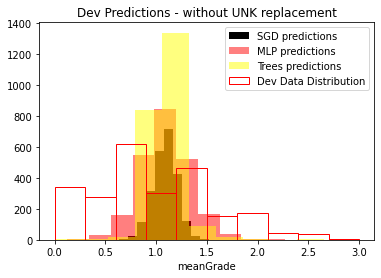

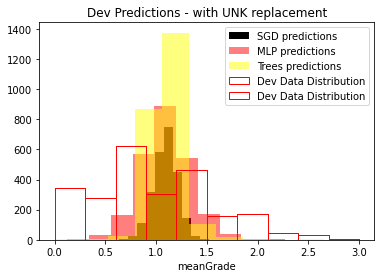

In [ ]:
display(results)
plt.figure()
plt.hist(prediction_list[0],  label = 'SGD predictions', color=(0,0,0,1))
plt.hist(prediction_list[1],  label = 'MLP predictions', color=(1,0,0,0.5))
plt.hist(prediction_list[2],  label = 'Trees predictions', color=(1,1,0,0.5))
plt.hist(preprocessed_dev_df["meanGrade"], label="Dev Data Distribution", color=(1,1,1, 0), edgecolor="r")
plt.legend()
plt.xlabel("meanGrade")
plt.title("Dev Predictions - without UNK replacement")
plt.savefig("augmented_dataset_dev_results_no_unk")

plt.figure()
plt.hist(prediction_list_unk[0],  label = 'SGD predictions', color=(0,0,0,1))
plt.hist(prediction_list_unk[1],  label = 'MLP predictions', color=(1,0,0,0.5))
plt.hist(prediction_list_unk[2],  label = 'Trees predictions', color=(1,1,0,0.5))
plt.hist(preprocessed_dev_df["meanGrade"], label="Dev Data Distribution", color=(1,1,1, 0), edgecolor="r")
plt.hist(label_per_sentence_test, label="Dev Data Distribution", color=(1,1,1, 0), edgecolor="r")
plt.legend()
plt.title("Dev Predictions - with UNK replacement")
plt.xlabel("meanGrade")
plt.savefig("augmented_dataset_dev_results_unk")

print("\n\n Words most similar to UNK")
word2vec_model_large.wv.most_similar(positive=['<UNK>'])


In [ ]:
# FINAL TESTING OF BEST MODEL ON TEST SET
# Train final best model on train set
w2v_repr_per_sentence, label_per_sentence = get_embeddings(word2vec_model_large, medium_unk_train_df, to_unk=False)

# Pre-process test dataset
test_data = preprocess_dataframe(final_test_df_w_labels.copy(), stopwords_removal=True, stemming=True, start_end_tok=False, original_word=True)
w2v_repr_per_sentence_test , label_per_sentence_test = get_embeddings(word2vec_model_large, test_data, to_unk=False)

# train best model
best_sgd = SGDRegressor(penalty="l1", learning_rate="adaptive", verbose=3).fit(w2v_repr_per_sentence, label_per_sentence)

# get predictions
predictions = best_sgd.predict(w2v_repr_per_sentence_test)
sse, mse = model_performance(predictions, label_per_sentence_test, True)
print("FINAL MSE", mse, "FINAL RMSE", np.sqrt(mse))

dict_to_save = {"sgd":list(predictions), "labels": list(label_per_sentence_test)}
dataframe = pd.DataFrame(dict_to_save)
dataframe.to_csv("sgd.csv")

with open("sgd_results.json", "w") as f:
  json.dump(dict_to_save, f)


Time to collect the word embeddings: 2.19 seconds
Original corpus length: 17900, Number of headlines skipped (out of vocab): 52
Step 1 (Lowercase): the latest : election tally shows cars turning right
Step 2 (Punctuation removal):  the latest  election tally shows cars turning right
Step 3 (Stopword removal): latest election tally shows cars turning right
Step 4 (Stemming): latest elect talli show car turn right
Time to collect the word embeddings: 0.39 seconds
Original corpus length: 3024, Number of headlines skipped (out of vocab): 126
-- Epoch 1
Norm: 5.79, NNZs: 76, Bias: 1.114349, T: 17848, Avg. loss: 0.868059
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 9.73, NNZs: 70, Bias: 0.990166, T: 35696, Avg. loss: 0.483931
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 12.89, NNZs: 63, Bias: 0.908085, T: 53544, Avg. loss: 0.367746
Total training time: 0.07 seconds.
-- Epoch 4
Norm: 15.65, NNZs: 44, Bias: 0.909930, T: 71392, Avg. loss: 0.315110
Total training time: 0.10 seconds

In [ ]:
print("\n\n Words most similar to UNK")
word2vec_model_large.wv.most_similar(positive=['<UNK>'])


{'sgd': [1.0296736162201967, 1.2118564475073497, 1.022154586831576, 1.0655692265919345, 1.2746165374744591, 1.17248960093837, 1.0901113578255193, 1.1811949873670011, 1.010514223312245, 1.0596383861050838, 1.0914498943732502, 1.1701973608627574, 1.0317148137197194, 0.8969245950920144, 0.9629752936285312, 1.1288074414860008, 1.1457103785490497, 1.1242491601359108, 1.2448840989601178, 1.1429142281206839, 1.0890886003409068, 0.8926581278751716, 1.0957390751041436, 1.3358837522781037, 1.1056662898263732, 1.0809186168874803, 1.2301684057639388, 0.986952545735399, 1.3145867652400958, 1.1343491947513835, 1.134025556354912, 1.190701063774861, 1.1446667408772637, 1.18730883158572, 1.34288339997518, 0.9458825946198393, 1.0834000233757082, 0.9197098948309919, 1.0196989390947993, 1.1764516718983833, 1.0792446616999039, 1.0827274708645738, 1.0049755836479932, 0.8961717743778785, 0.9755430550533795, 1.0753913452848791, 1.0170777156821385, 1.20634093521514, 0.9584589166771773, 1.1285482097440782, 1.16

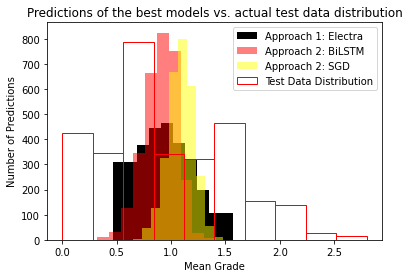

In [ ]:
#### PLOTTING FINAL HISTOGRAMS

# LOAD FILES HERE


import json
with open('LSTM_A2_results.json') as f:
  pred_LSTM = json.load(f)

with open('electra_results.json') as f:
  pred_electra = json.load(f)

with open('part2SGD.json') as f:
  pred_SGD = json.load(f)

print(pred_SGD)

plt.figure()
plt.hist(pred_electra['predictions'],  label = 'Approach 1: Electra', color=(0,0,0,1))
plt.hist(pred_LSTM['predictions'],  label = 'Approach 2: BiLSTM', color=(1,0,0,0.5))
plt.hist(pred_SGD["sgd"],  label = 'Approach 2: SGD', color=(1,1,0,0.5))
plt.hist(final_test_df_w_labels['meanGrade'], label="Test Data Distribution", color=(1,1,1, 0), edgecolor="r")
plt.legend()
plt.title("Predictions of the best models vs. actual test data distribution")
plt.xlabel("Mean Grade")
plt.ylabel("Number of Predictions")
plt.savefig("FINAL_TEST_HIST")


### Subword Methods
FastText Implementation

Byte Pair encoding (in additional experiements section)



In [ ]:
# train word to vec with the larger corpus (funlines + news headlines)

# Get preprocessed headlines
preprocessed_train_df = preprocess_dataframe(train_df, start_end_tok = False, merge_headlines = True, original_word = True)

# Get additional preprocessed funlines
preprocessed_funlines = preprocess_dataframe(funlines_df, start_end_tok = False, merge_headlines = True, original_word = True)

# Build a large W2V training corpus
medium_preprocessed_train_df = pd.concat([preprocessed_train_df, preprocessed_funlines])
large_preprocessed_train_df = enrich_headline_data(medium_preprocessed_train_df['edited_headline'], headlines_df, verbose = True)

# get tokenised corpus
large_vocab, large_tokenised_corpus = create_vocab(large_preprocessed_train_df)

# Replace rare words in corpus with UNK tokens
# medium unk train df is the labelled + preprocessed funlines + original dataset for training
large_tokenised_corpus, medium_unk_train_df =  rare_words_removal(tokenised_corpus=large_tokenised_corpus, unk_threshold = 1, dataframe = medium_preprocessed_train_df, replace_in_dataframe = True)

display(medium_unk_train_df.head())

Step 1 (Lowercase): france is ‘ hunting down its citizens who joined twins ’ without trial in iraq
Step 2 (Punctuation removal):  france is  hunting down its citizens who joined twins  without trial in iraq
Step 3 (Stopword removal): france hunting citizens joined twins without trial iraq
Step 4 (Stemming): franc hunt citizen join twin without trial iraq
Step 6 (Merge): franc hunt citizen join isi without trial iraq franc hunt citizen join twin without trial iraq
Step 1 (Lowercase): donald trump misunderstands g7 talks on climate crisis and amazon fires
Step 2 (Punctuation removal):  donald trump misunderstands g7 talks on climate crisis and amazon fires
Step 3 (Stopword removal): donald trump misunderstands g7 talks climate crisis amazon fires
Step 4 (Stemming): donald trump misunderstand g7 talk climat crisi amazon fire
Step 6 (Merge): donald trump skip g7 talk climat crisi amazon fire donald trump misunderstand g7 talk climat crisi amazon fire
Incresed size of input data to 218753
D

id  ...                                    edited_headline
0  14530  ...  franc hunt citizen join isi without trial iraq...
1  13034  ...  pentagon claim 2000 increas russian troll syri...
2   8731  ...  iceland pm call snap vote pedophil furor crash...
3     76  ...  appar first iran israel engag militarili appar...
4   6164  ...  trump told week ago flynn misl vice presid tru...

[5 rows x 8 columns]

In [ ]:
# FastText
# https://radimrehurek.com/gensim/auto_examples/tutorials/run_fasttext.html#sphx-glr-auto-examples-tutorials-run-fasttext-py

# The main principle behind fastText is that the morphological structure of a word carries important information about the meaning of the word. 
# Such structure is not taken into account by traditional word embeddings like Word2Vec, which train a unique word embedding for every individual word
# can break down OOV words into n-grams and treat that way

from gensim.models import FastText

t = time.time()

fast_text_large = FastText(size=100, window=5) 
fast_text_large.build_vocab(large_tokenised_corpus, min_count=1)

fast_text_large.train(
    large_tokenised_corpus, total_examples=fast_text_large.corpus_count, total_words=fast_text_large.corpus_total_words, epochs=30, report_delay=1)


print('Time to train the word embeddings: {} seconds'.format(round((time.time() - t), 2)))


Time to train the word embeddings: 252.36 seconds


Step 1 (Lowercase): thousands of gay and bisexual swans convicted of long-abolished sexual offences are posthumously pardoned
Step 2 (Punctuation removal):  thousands of gay and bisexual swans convicted of longabolished sexual offences are posthumously pardoned
Step 3 (Stopword removal): thousands gay bisexual swans convicted longabolished sexual offences posthumously pardoned
Step 4 (Stemming): thousand gay bisexu swan convict longabolish sexual offenc posthum pardon
Time to collect the word embeddings: 1.99 seconds
Original corpus length: 17900, Number of headlines skipped (out of vocab): 0
Time to collect the word embeddings: 0.27 seconds
Original corpus length: 2419, Number of headlines skipped (out of vocab): 0
Training the model
-- Epoch 1
Norm: 928612319400.44, NNZs: 100, Bias: -87667027945.886902, T: 17900, Avg. loss: 1987462799344392994816000.000000
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 990049140915.03, NNZs: 100, Bias: 17001089223.481085, T: 35800, Avg. loss: 20

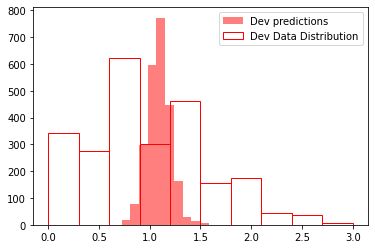

In [ ]:
# Best model from Word2Vec GridSearch on Large Dataset
best_model = SGDRegressor(learning_rate="adaptive", penalty="l1", verbose=3)

# train on train set, test on dev set
train_data = medium_unk_train_df
dev_data = preprocess_dataframe(dev_df_w_labels.copy(), stopwords_removal=True, stemming=True, start_end_tok=False, original_word=True)


# Get the wv representation using W2V large and the corresponding mean grade for training regressor
print('Collecting original and edited word vectors for training:')
w2v_repr_per_sentence, label_per_sentence = get_embeddings(fast_text_large, train_data, to_unk = False)

print("Collecting original and edited word vectors for training:")

w2v_repr_per_sentence_dev, label_per_sentence_dev = get_embeddings(fast_text_large, dev_data, to_unk = False)

# TRAIN THE MODEL
print("Training the model")
best_model.fit(w2v_repr_per_sentence, label_per_sentence)
predictions_train = best_model.predict(w2v_repr_per_sentence)
predictions_dev = best_model.predict(w2v_repr_per_sentence_dev)
print("Evaluating the SGR Regressor")
# We run the evaluation:
print("\nTrain performance:")
sse, mse = model_performance(predictions_train, label_per_sentence, True)

print("\nDev performance:")
sse, mse = model_performance(predictions_dev, label_per_sentence_dev, True)
print("MSE", mse, "RMSE", np.sqrt(mse))

plt.figure()
plt.hist(predictions_dev,  label = 'Dev predictions', color=(1,0,0,0.5))
plt.hist(preprocessed_dev_df["meanGrade"], label="Dev Data Distribution", color=(1,1,1, 0), edgecolor="r")
plt.savefig("FastText Extratrees.jpg")
plt.legend()



### Model Training (RNN)

In [ ]:
#Preprocess the data so that it matches the format used in Approach 1

class gensimDataset(Dataset):

    def __init__(self, w2v_model, tokenized_original, tokenized_edited, train_df, merge = False):
        self.model_w2v = w2v_model
        self.y_train = train_df['meanGrade']
        self.merge = merge
        if merge:
            self.x_train = self.get_indices(tokenized_edited)
        else:
            original = self.get_indices(tokenized_original)
            edited = self.get_indices(tokenized_edited)
            self.x_train = list(zip(original, edited))
    
    # We add padding to our minibatches and create tensors for our model
    def collate_fn_padd(self, batch):
      
        if self.merge:
            batch_features = [f for f, l in batch]
            batch_labels = [l for f, l in batch]
            
            seq_tensor = self.add_padding(batch_features)
            
            batch_labels = torch.FloatTensor(batch_labels)
                
            return seq_tensor, batch_labels
            
        else:
            batch_features_o = [f[0] for f, l in batch]
            batch_features_e = [f[1] for f, l in batch]
            batch_labels = [l for f, l in batch]
            
            if len(batch_features_o) != len(batch_features_e):
                print('ERROR! Original and edited batch lengths different')
            
            dict_tensor = {}
            dict_tensor['original'] = self.add_padding(batch_features_o)
            dict_tensor['edited'] = self.add_padding(batch_features_e)
            
            batch_labels = torch.FloatTensor(batch_labels)
            
            return dict_tensor, batch_labels
            
    def add_padding(self, features):
        features_len = [len(f) for f in features]
            
        seq_tensor = torch.zeros((len(features), max(features_len))).long()

        for idx, (seq, seqlen) in enumerate(zip(features, features_len)):
            seq_tensor[idx, :seqlen] = torch.LongTensor(seq)
            
        return seq_tensor
    
    # Get indexed corpus
    def get_indices(self, tokenised_corpus):

        indexed_corpus = [[self.model_w2v.wv.vocab.get(word).index if word in self.model_w2v.wv.vocab else self.model_w2v.wv.vocab.get('<UNK>').index for word in headline] for headline in tokenised_corpus]

        return indexed_corpus

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        return self.x_train[item], self.y_train[item]

In [ ]:
# Train on the entire training set, test on dev set

# Set hyperparameters
k_folds = 1
embedding_dim = 100
hidden_dim = 50
batch_size = 16
epochs = 10
lr = 0.001
lr_embedding = 0.0005
ffnn_layers = [20]
num_lstm_layers = 1
combo = 'edited_only'
freeze = False

# Define which W2V model and data to use
w2v_model = word2vec_model_large
tok_corpus = large_tokenised_corpus[:len(train_df)]
dev_data = preprocess_dataframe(dev_df_w_labels.copy(), stopwords_removal=True, stemming=True, start_end_tok=False, original_word=True)
_, tok_corpus_dev = create_vocab(dev_data['edited_headline'])

k_train_losses = []
k_val_losses = []
train_losses = []
val_losses = []

for k in range(k_folds):
    print()
    print(f'Running fold {k} with freeze {freeze}, lr embedding {lr_embedding}')

    original = []
    edited = []
    original_dev = []
    edited_dev = []
    # Split into original and edited
    for headline in tok_corpus:
        #Split into original and edited headline
        original.append(headline[:int(np.round((len(headline)/2)))])
        edited.append(headline[int(np.round((len(headline)/2))):])

    for headline in tok_corpus_dev:
        #Split into original and edited headline
        original_dev.append(headline[:int(np.round((len(headline)/2)))])
        edited_dev.append(headline[int(np.round((len(headline)/2))):])

    # Train Test split
    original_train_split_df = original
    original_dev_df = original_dev
    edited_train_split_df = edited
    edited_dev_df = edited_dev
    train_split_df = train_df
    dev_df = dev_df_w_labels
  
    
    assert len(original_train_split_df)==len(train_split_df)

    # Prepare data for training
    train_dataset = gensimDataset(w2v_model, original_train_split_df, edited_train_split_df, train_split_df, merge = False)
    dev_dataset = gensimDataset(w2v_model, original_dev_df, edited_dev_df, dev_df, merge = False)

    # Initialise model
    model = BiLSTM(embedding_dim, hidden_dim, batch_size, torch.FloatTensor(w2v_model.wv.vectors), num_lstm_layers = num_lstm_layers, ffnn_layers = ffnn_layers, combination = combo, freeze_embedding = freeze)
    model.to(device)

    print(f'Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

    # Create dataloaders
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size, collate_fn=train_dataset.collate_fn_padd)
    dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=batch_size, collate_fn=dev_dataset.collate_fn_padd)

    # Set loss function
    loss_fn = rmse

    # Initialise optimiser and learning rate scheduler
    optimizer = torch.optim.AdamW(params, lr=lr, eps = 1e-8)
    lambda_scheduler = lambda epoch: 0.98 ** epoch
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_scheduler)

    # Train model
    t_loss, v_loss = train(train_loader, dev_loader, model, epochs, loss_fn, optimizer, scheduler)
    torch.save(model.state_dict(), f'model_{k}.pickle')

    # Store losses
    train_losses.append(t_loss)
    val_losses.append(v_loss)

k_train_losses.append(train_losses)
k_val_losses.append(val_losses)
    
# Save model
with open('rnn_final_run.pickle', 'wb') as f:
    pickle.dump((k_train_losses, k_val_losses), f)

Step 1 (Lowercase): thousands of gay and bisexual swans convicted of long-abolished sexual offences are posthumously pardoned
Step 2 (Punctuation removal):  thousands of gay and bisexual swans convicted of longabolished sexual offences are posthumously pardoned
Step 3 (Stopword removal): thousands gay bisexual swans convicted longabolished sexual offences posthumously pardoned
Step 4 (Stemming): thousand gay bisexu swan convict longabolish sexual offenc posthum pardon

Running fold 0 with freeze False, lr embedding 0.0005
Number of trainable parameters: 2773441
Training model.
0.1091 | Epoch: 01 | Train Loss: 0.9347 | Train MSE: 0.8895 | Train RMSE: 0.9431 |         Val. Loss: 0.9199 | Val. MSE: 0.8563 |  Val. RMSE: 0.9254 |
0.2117 | Epoch: 02 | Train Loss: 0.9339 | Train MSE: 0.8851 | Train RMSE: 0.9408 |         Val. Loss: 0.9199 | Val. MSE: 0.8563 |  Val. RMSE: 0.9254 |
0.3163 | Epoch: 03 | Train Loss: 0.9338 | Train MSE: 0.8873 | Train RMSE: 0.9419 |         Val. Loss: 0.9199 | Val

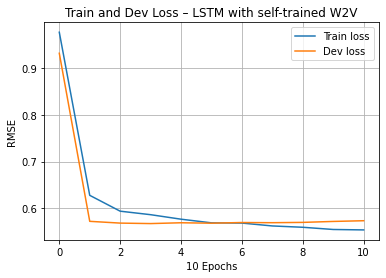

In [ ]:
# Plot the loss curves
k_train_losses_np = np.array(k_train_losses)
k_val_losses_np = np.array(k_val_losses)

k_train_losses_np = k_train_losses_np.mean(axis=1)
k_val_losses_np = k_val_losses_np.mean(axis=1)

fig = plt.plot( figsize=(4.8, 4.8))

plt.plot(k_train_losses_np[0,:], label='Train loss')
plt.plot(k_val_losses_np[0,:], label='Dev loss')
plt.grid()
plt.legend()
plt.title("Train and Dev Loss – LSTM with self-trained W2V")
plt.xlabel('10 Epochs')
plt.ylabel('RMSE')
plt.savefig('rnn_w2v.png')

In [ ]:
# Pre-process test dataset
test_data = preprocess_dataframe(final_test_df_w_labels.copy(), stopwords_removal=True, stemming=True, start_end_tok=False, original_word=True)
_, tok_corpus_test = create_vocab(test_data['edited_headline'])

original_test = []
edited_test = []

for headline in tok_corpus_test:
    original_test.append(headline[:int(np.round((len(headline)/2)))])
    edited_test.append(headline[int(np.round((len(headline)/2))):])

test_dataset = gensimDataset(w2v_model, original_test, edited_test, final_test_df_w_labels, merge = False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, collate_fn=dev_dataset.collate_fn_padd)

predictions = []
targets = []

# Get predictions on the test data
for i, batch in enumerate(test_loader):
            feature, target = batch
            
            target = target.to(device)
            for k, v in feature.items():
                feature[k] = feature[k].to(device)

            model.batch_size = target.shape[0]

            predictions.append(model(feature).squeeze(1).detach().to('cpu').numpy())
            targets.append(target.detach().to('cpu').numpy())

# Calculate MSE and RMSE on test set
print("")
print("MSE & RMSE ON TEST SET")
sse, mse = model_performance(np.array(predictions).flatten(), np.array(targets).flatten(), True)

Step 1 (Lowercase): the latest : election tally shows cars turning right
Step 2 (Punctuation removal):  the latest  election tally shows cars turning right
Step 3 (Stopword removal): latest election tally shows cars turning right
Step 4 (Stemming): latest elect talli show car turn right

MSE & RMSE ON TEST SET
| MSE: 0.3337 | RMSE: 0.5776 |


In [ ]:
#Save predictions from test data
import json
with open("LSTM_A2_results.json", "w") as f:
    json.dump({"predictions": [float(p) for p in np.array(predictions).flatten()]}, f, indent=3)

name  dev RMSE with UNK  ...  dev RMSE w/o UNK  dev MSE w/o UNK
0         SGD           0.592191  ...          0.590030         0.348135
1         MLP           0.619193  ...          0.618561         0.382618
2  ExtraTrees           0.607219  ...          0.606158         0.367427

[3 rows x 5 columns]



 Words most similar to UNK


[('celler', 0.526521623134613),
 ('toro', 0.5140600204467773),
 ('allan', 0.5137248039245605),
 ('schulnik', 0.5080114603042603),
 ('deen', 0.5002561807632446),
 ('yasmin', 0.4948054552078247),
 ('chiara', 0.49044904112815857),
 ('eubank', 0.4876002371311188),
 ('glenda', 0.4861345589160919),
 ('novo', 0.48073017597198486)]

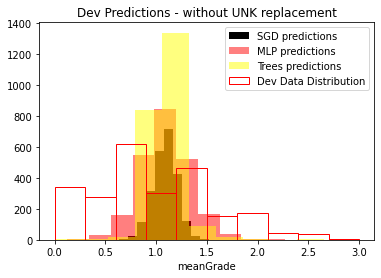

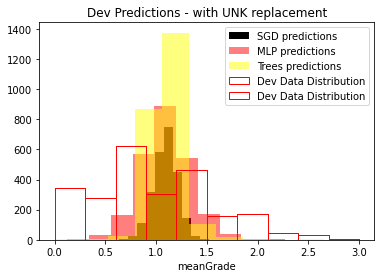

In [ ]:

plt.figure()
plt.hist(prediction_list[0],  label = 'SGD predictions', color=(0,0,0,1))
plt.hist(prediction_list[1],  label = 'MLP predictions', color=(1,0,0,0.5))
plt.hist(prediction_list[2],  label = 'Trees predictions', color=(1,1,0,0.5))
plt.hist(preprocessed_dev_df["meanGrade"], label="Dev Data Distribution", color=(1,1,1, 0), edgecolor="r")
plt.legend()
plt.xlabel("meanGrade")
plt.title("Dev Predictions - without UNK replacement")
plt.savefig("augmented_dataset_dev_results_no_unk")

plt.figure()
plt.hist(prediction_list_unk[0],  label = 'SGD predictions', color=(0,0,0,1))
plt.hist(prediction_list_unk[1],  label = 'MLP predictions', color=(1,0,0,0.5))
plt.hist(prediction_list_unk[2],  label = 'Trees predictions', color=(1,1,0,0.5))
plt.hist(preprocessed_dev_df["meanGrade"], label="Dev Data Distribution", color=(1,1,1, 0), edgecolor="r")
plt.hist(label_per_sentence_test, label="Dev Data Distribution", color=(1,1,1, 0), edgecolor="r")
plt.legend()
plt.title("Dev Predictions - with UNK replacement")
plt.xlabel("meanGrade")
plt.savefig("augmented_dataset_dev_results_unk")

print("\n\n Words most similar to UNK")
word2vec_model_large.wv.most_similar(positive=['<UNK>'])



# Additional Experiements



1.   manual byte pair encoding
2.   manual word embedding training




Pytorch Word Embeddings  --> Inefficient! Therefore used gensim


In [ ]:
##############################
### Create word embeddings ### >> Inefficient! Therefore used gensim
##############################

# Get vocab and tokenised corpus
vocab, tokenized_corpus = preprocessing(train_df, unk_threshold = 2, start_end_tok = True, merge_headlines = True)

from tqdm import tqdm 

# Training parameters
num_epochs = 100
learning_rate = 0.001

for epoch in tqdm(range(num_epochs)):
  
  loss_val = 0
  
  for data, target in idx_pairs:
    
    x = torch.Tensor(one_hot_lookup(data, vocab_size))

    y_true = torch.Tensor([target]).long()

    z1 = torch.matmul(W1, x) 
    z2 = torch.matmul(W2, z1)

    log_softmax = nn.functional.log_softmax(z2, dim=0)

    loss = nn.functional.nll_loss(log_softmax.view(1,-1), y_true)
    loss_val += loss.item()
    
    # Backward pass
    loss.backward()
    
    # Gradient descent
    W1.data -= learning_rate * W1.grad.data
    W2.data -= learning_rate * W2.grad.data

    # Zero out gradient accumulation
    W1.grad.data.zero_()
    W2.grad.data.zero_()

print(f'\nFinal epoch loss: {loss_val/len(idx_pairs)}')


Step 1 (Created edited headline): France is ‘ hunting down its citizens who joined twins ’ without trial in Iraq
Step 2 (Lowercase): france is ‘ hunting down its citizens who joined twins ’ without trial in iraq
Step 3 (Punctuation removal):  france is  hunting down its citizens who joined twins  without trial in iraq
Step 4 (Stopword removal): france hunting citizens joined twins without trial iraq
Step 5 (Stemming): franc hunt citizen join twin without trial iraq
Step 6 (Start & end tokens): <s> franc hunt citizen join twin without trial iraq <\s>
Step 9: The following words will be replaced by UNK token:
Words with occurance 0 : ['<s>', '<\\s>']
Words with occurance 1 : ['looni', 'bloat', 'pilat', 'booger', 'aspir', 'grit', 'sadist', 'turpentin', 'seesaw', 'contin', 'iq', 'sabl', 'pornographi', 'batman', 'simpleton', 'sauna', 'shiver', 'incarcer', 'granola', 'assimil', 'microsecond', 'bellboy', 'routin', 'tostada', 'whatev', 'censur', 'silli', 'kennel', 'jive', 'cranial', 'trophi', 

Byte Pair Encoding: Inefficient! Therefore used FastText

In [ ]:
preprocessed_df = preprocess_dataframe(train_df.copy(), stemming=False, start_end_tok=False, original_word=True)
vocab, tokenised_corpus = create_vocab(preprocessed_df["edited_headline"])

# Example 
mini_corpus = tokenised_corpus[0]

print("corpus", mini_corpus)

# store variables for BPE vocab
V_bpe = list(set("".join(mini_corpus))) # original character vocab
print("original character vocab", V_bpe)

def get_tokens(mini_corpus: list) -> Counter:
  '''
  Preprocesses corpus for BPE - splits words into characters + adds end of word token
  '''
  # put spaces between characters in word and add EOW character
  tokens = [" ".join(list(word)) + r" <\w>" for word in mini_corpus]
  # dict of counts
  return Counter(tokens)

def get_pair_counts(vocab: Counter) -> dict:
  '''
  Counts frequency of all potential token pairs
  '''
  pairs = defaultdict(int) # create an empty dict TBU
  for word, frequency in vocab.items():
    symbols = word.split()
    # get pall airs from words + count frequency of appearace
    for i in range(len(symbols) -1):
      pairs[symbols[i], symbols[i+1]] += frequency
  return pairs



def merge(pair: tuple, v_in: dict) -> dict:
    '''
    Merges the input pair in the vocabulary, returns the updated vocab
    '''
    v_out = {} # to store updated vocabulary
    bigram = re.escape(' '.join(pair)) # escape the most frequent bigram for use in regex
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    replacement = re.escape(''.join(pair))
    for word in v_in:
        # join together the most frequent bigram only in the vocab
        w_out = p.sub(replacement, word)
        v_out[w_out] = v_in[word]
    # return updated vocab
    return v_out


def run_bpe(num_merges: int, vocab: Counter):
  '''
  Iterates:
  1) find all eligible pairs + their frequency from vocab
  2) merge most frequent pair

  Repeat x num_merges

  Returns: final vocab, list of merges conducted in order, tokenised vocab

  '''

  stored_merges = []
  t=time.time()
  tokens_to_process = []
  for i in range(num_merges):
    # get byte pairs
    pairs = get_pair_counts(vocab)  
    # print(f"iteration {i}", pairs)

    # get most frequent pair
    best = max(pairs, key=pairs.get)
    # add to vocab bpe
    V_bpe.append("".join(best))
    # keep track of merges in order for test time
    stored_merges.append(best)
    print(f"Iteration {i}; merging {best}; frequency {pairs[best]}")
    vocab = merge(best, vocab)

    for key, _ in vocab.items():
      tokens = key.strip("<\w>").split()
      tokens_to_process.extend(tokens)
  print("BPE training finished {} merges completed in {}s".format(num_merges, round((time.time() - t), 2)))
  return vocab, stored_merges, tokens_to_process

def encode_bpe(new_words, stored_merges):
  '''
  1) preprocesses corpus for BPE - splits into characters + EOW token
  2) iterates through the vocab, applying all possible merges from stored_merges list until no more can be applied
  Returns the tokenised vocabulary
  '''
  # this function takes a while on a large corpus
  print("Encoding", new_words)
  t=time.time()
  iteration = 0
  vocab = get_tokens(new_words)
  while True:
    
    print(f"iteration: {iteration}")
    pairs = get_pair_counts(vocab)

    # get available merges
    merges = [stored_merges.index(i) for i in pairs if i in stored_merges]
    # print("merges", merges)

    if len(merges) == 0:
      print("BPE finished {} merges completed in {}s".format(iteration, round((time.time() - t), 2)))
      break
    
    # apply most frequent merge
    vocab = merge(stored_merges[min(merges)], vocab)
    iteration+=1
  tokens_to_process = []
  
  for key, _ in vocab.items():
    tokens = key.strip("<\w>").split()
    tokens_to_process.extend(tokens)
  
  return tokens_to_process

# RUN BPE
vocab = get_tokens(mini_corpus)
print("original vocab", vocab)
t = time.time()
bpe_runs = 10
vocab, stored_merges, tokens_to_process = run_bpe(bpe_runs, vocab)
print('Time to run {} iterations of bpe: {} seconds'.format(bpe_runs, round((time.time() - t), 2)))
print("final vocab", vocab)
print("stored merges", stored_merges)


new_words = ["train", "france"]
tokens_to_process = encode_bpe(new_words, stored_merges)
print("Processed test words: ", tokens_to_process)


Step 1 (Lowercase): france is ‘ hunting down its citizens who joined twins ’ without trial in iraq
Step 2 (Punctuation removal):  france is  hunting down its citizens who joined twins  without trial in iraq
Step 3 (Stopword removal): france hunting citizens joined twins without trial iraq
corpus ['france', 'hunting', 'citizens', 'joined', 'twins', 'without', 'trial', 'iraq']
original character vocab ['a', 'u', 'n', 'o', 'e', 'l', 'c', 'q', 'z', 'f', 'w', 'j', 'g', 't', 'h', 'd', 'r', 'i', 's']
original vocab Counter({'f r a n c e <\\w>': 1, 'h u n t i n g <\\w>': 1, 'c i t i z e n s <\\w>': 1, 'j o i n e d <\\w>': 1, 't w i n s <\\w>': 1, 'w i t h o u t <\\w>': 1, 't r i a l <\\w>': 1, 'i r a q <\\w>': 1})
Iteration 0; merging ('i', 'n'); frequency 3
Iteration 1; merging ('r', 'a'); frequency 2
Iteration 2; merging ('i', 't'); frequency 2
Iteration 3; merging ('s', '<\\w>'); frequency 2
Iteration 4; merging ('f', 'ra'); frequency 1
Iteration 5; merging ('fra', 'n'); frequency 1
Iterati